<img src="https://arbiterz.com/wp-content/uploads/2023/05/Bank_of_England_Logo.png" alt="Me :)" width="300"/>

# Employer Project: Bank of England

# Dream Team

#

<a id="Table_of_contents"></a>
# Table of Contents

### 1. Data ingestion and Initial Inspection

1.1 **[Introduction](#Introduction)**
   
1.2 **[Key information from the Metadata](#Key_information_from_the_Metadata)** \
   I. Original and Final Data after Analysis

1.3 **[Setting up the Notebook workflow](#Setting-up-the-Notebook-workflow)** \
    I. Imports\
    II. Configuration settings and constants\
    III. Functions to load and save data

1.4 **[Sense Checking the DataFrames](#Sense_Checking_the_DataFrames)**


### 2. FinBert Sentiment Analysis

2.1 **[FinBert Sentiment Anlysis](#FinBert_Sentiment_Analysis)** \
    I. 1st Attempt and visualisations (512 Tokens Truncation) \
    II. 2nd Attempt and visualisations (FinBert by Statements) \
    III. Visualisations


> **Objective:**
  > Generate a sentiment score classification (final df creates finbert_speeches.csv).

### 3. Correlation Analysis: OLS Regression

3.0 **[DataFrames Merge](#DataFrames_Merge)**

3.1 **[Simple Linear Regression](#Simple_Linear_Regression)** \
    I. Correlation Matrix \
    II. Simple Linear Regression for each of the variables
    
3.2 **[Multiple Linear Regression](#Multiple_Linear_Regression)** \
    I. Variance-inflation Factor (VIF) \
    II. Multiple Linear Regression 


> **Objective:**
  > Identify correlations between sentiment and economic indicators.

### 4. Correlation Analysis: Vector Autoregression (VAR) Model
 
4.1 **[Vector Autoregression (VAR) Model](#Vector_Autoregression_(VAR)_Model)** \
    I. Data Preparation \
    II. Model Fit and Visualisations

> **Objective:**
  > Analyse dynamic interactions between sentiment and economic indicators.

#

# 1. Data ingestion and Initial Inspection

<a id="Introduction"></a>
## 1.1 Introduction

This notebook is the second in a series of four, focusing on sentiment and correlation analysis of Bank of England speeches and financial market indicators. It begins by loading and inspecting the cleaned data, reviewing metadata for context.

For sentiment analysis, FinBERT is applied using two approaches. In the **512 Tokens Truncation** approach, each speech is divided into 512-token segments, with an average sentiment score calculated across segments. The **FinBERT by Statements** approach anasyzes each speech statement individually, then averages the sentiment scores for a more granular but computationally intensive result. Comparing these methods helps determine if per-statement analysis yields deeper insights or if segment averaging suffices.

Correlation analysis follows, using linear regression and Vector Autoregression (VAR) to explore relationships between sentiment scores and economic indicators over time.

**Stages of analysis:**

- Data ingestion and Initial Inspection
- FinBert Sentiment Analysis
- Correlation Analysis: OLS Regression
- Correlation Analysis: Vector Autoregression (VAR) Model


##

<a id="Key_information_from_the_Metadata"></a>
## 1.2 Key information from the metadata:

### I. Original and Final Data after Analysis

The *BoE_2* notebook begins with two primary datasets originated in *BoE_1*:

1. **clean_speeches.csv**: Loaded as the *speeches* DataFrame, it underwent two FinBERT sentiment analysis attempts:
- **512 Tokens Truncation**provided more granular sentiment scores, saved as multiple files, including *finbert_1_speeches_03_07.csv* through *finbert_1_speeches_18_22.csv*).
- **FinBERT by Statements** generated sentiment classifications, resulting in similar output files (e.g., *finbert_2_speeches_03_07.csv* through *finbert__speeches_21_22.csv*. 

   
2. **clean_economic_indicators.csv**: Brought into the analysis as *economic_indicators* DataFrame, it was merged with *finbert_speeches_1.csv* to create the combined *merged_df.csv* file for correlation analysis. 

Each processed file has sentiment scoring and supports correlation analysis in the subsequent stages, through simple and multiple linear regression and vector autoregression models.

##

<a id="Setting-up-the-Notebook-workflow"></a>
## 1.3 Setting up the Notebook workflow

### I. Imports

In [1]:
# General Utilities 
import os
import sys
import math
import logging
import subprocess
from datetime import datetime
import warnings
from collections import Counter
import re

# Data manipulation and processing
import pandas as pd
import numpy as np

# Time series analysis
import statsmodels.api as sm
import statsmodels.formula.api as smf
from statsmodels.tsa.stattools import adfuller


# Data visualisation
import matplotlib.pyplot as plt
import seaborn as sns
from matplotlib.backends.backend_pdf import PdfPages
from matplotlib import cm
from wordcloud import WordCloud

# Text processing and NLP
import nltk
from nltk.tokenize import word_tokenize
from nltk.corpus import stopwords
from nltk.stem import WordNetLemmatizer
from nltk.probability import FreqDist
from nltk.sentiment.vader import SentimentIntensityAnalyzer
from textblob import TextBlob
import spacy

# Modelling and training
from sklearn.linear_model import LinearRegression
from sklearn.tree import DecisionTreeRegressor, plot_tree
from sklearn.ensemble import RandomForestRegressor
from sklearn.cluster import KMeans
from sklearn.decomposition import LatentDirichletAllocation
from statsmodels.tsa.api import VAR

# Model evaluation and metrix
from sklearn import metrics
from sklearn.metrics import (
    accuracy_score, confusion_matrix, ConfusionMatrixDisplay,
    classification_report, mean_squared_error, mean_absolute_error, 
    r2_score, silhouette_score
)
from sklearn.model_selection import train_test_split, cross_val_score, learning_curve

# Data processing
from sklearn.preprocessing import LabelEncoder, StandardScaler
from sklearn.feature_extraction.text import CountVectorizer

# Statistical test
from scipy import stats
from scipy.stats import shapiro, norm
from statsmodels.stats.outliers_influence import variance_inflation_factor
from statsmodels.formula.api import ols

# Deep leearning
import torch
from transformers import (
    AutoTokenizer, AutoModelForSequenceClassification, pipeline, 
    BertTokenizer, BertForSequenceClassification
)

# Notenoo setting
warnings.filterwarnings("ignore")
plt.rcParams['figure.figsize'] = [15, 10]



###

### II. Configuration settings and constants

In [2]:
# To print your directory
current_directory = os.getcwd()
print("Current Directory:", current_directory)

Current Directory: C:\Users\user\Desktop\BoE\Data\core_data_sets


In [3]:
# Configuration settings and constants

# Suppress FutureWarning
warnings.filterwarnings("ignore")

# Suppress informational messages
logging.getLogger('matplotlib').setLevel(logging.WARNING)

# Insert your own directory where data files are stored. Use \\
# sign to separate in the path. 
DATA_PATH = (r'C:\Users\user\Desktop\BoE\Data\core_data_sets')  
# Directory path where output files will be saved
OUTPUT_PATH = DATA_PATH
# Ensure the directories exist
LOG_FILE = os.path.join(OUTPUT_PATH, 'analysis.log')  # Log file path

os.makedirs(DATA_PATH, exist_ok=True)
os.makedirs(OUTPUT_PATH, exist_ok=True)

# Set up logging
logging.basicConfig(level=logging.INFO,
                    format='%(asctime)s - %(levelname)s - %(message)s', handlers=[
    logging.FileHandler(LOG_FILE),
    logging.StreamHandler()
])

# Version information
__version__ = "1.0.0"

# Print version
print(f"Current version: {__version__}")

print("Configuration settings:")
print(f"DATA_PATH: {DATA_PATH}")
print(f"OUTPUT_PATH: {OUTPUT_PATH}")
print(f"Output path exists: {os.path.exists(OUTPUT_PATH)}")
print(f"Output path is writable: {os.access(OUTPUT_PATH, os.W_OK)}")
print(f"LOG_FILE: {LOG_FILE}")

Current version: 1.0.0
Configuration settings:
DATA_PATH: C:\Users\user\Desktop\BoE\Data\core_data_sets
OUTPUT_PATH: C:\Users\user\Desktop\BoE\Data\core_data_sets
Output path exists: True
Output path is writable: True
LOG_FILE: C:\Users\user\Desktop\BoE\Data\core_data_sets\analysis.log


###

### III. Functions to load and save data

In [7]:
def load_multiple_files(file_paths):
    dataframes = {}
    
    for file_path in file_paths:
        try:
            file_name = file_path.split('/')[-1].split('.')[0]
            if file_path.endswith('.csv'):
                df = pd.read_csv(file_path)
            elif file_path.endswith('.xlsx') or file_path.endswith('.xls'):
                df = pd.read_excel(file_path)
            else:
                logging.warning(f"Unsupported file format: {file_path}")
                continue

            dataframes[file_name] = df
            logging.info(f"Data loaded successfully from {file_path}")
        except Exception as e:
            logging.error(f"Error loading data from {file_path}: {str(e)}")

    return dataframes


In [9]:
# Apply the function
file_list = ['clean_speeches.csv', 'clean_economic_indicators.csv']
dataframes_dict = load_multiple_files(file_list)

2024-11-21 16:24:38,773 - INFO - Data loaded successfully from clean_speeches.csv
2024-11-21 16:24:38,795 - INFO - Data loaded successfully from clean_economic_indicators.csv


In [11]:
# Function to save results
def save_results(df, file_path):
    if df is None:
        logging.error(f"Cannot save results to {file_path}: DataFrame is None")
        return
    try:
        logging.info(f'Saving results to {file_path}')
        df.to_csv(file_path, index=False)
        logging.info(f'Successfully saved results to {file_path}')
    except Exception as e:
        logging.error(f"Error saving file to {file_path}: {str(e)}")
        raise
        
# Optional, to save it to pickle for faster file handling
# def save_to_pickle(df, file_path):
    #logging.info(f'Saving DataFrame to {file_path}')
    #df.to_pickle(file_path)

# def load_from_pickle(file_path):
    #logging.info(f'Loading DataFrame from {file_path}')
    #return pd.read_pickle(file_path)

# Utility function to save plots
def save_plot(filename):
    plt.savefig(filename, bbox_inches='tight')
    print(f"Plot saved to {filename}")

In [13]:
def save_plots_to_pdf(plot_functions, pdf_path=None):
    """
    Generates and saves multiple plots to a single PDF file if a path is provided.
    """
    if pdf_path:
        with PdfPages(pdf_path) as pdf:
            for plot_func in plot_functions:
                # Clear any existing figures
                plt.close('all') 
                # Call the plotting function to create the plots
                plot_func()
                # Save all open figures to the PDF
                for figure in [plt.figure(i) for i in plt.get_fignums()]:
                    pdf.savefig(figure)
                # Close all figures after saving
                plt.close('all')
        print(f"Plots saved to {pdf_path}")
    else:
        # Display the plots if no path is specified
        for plot_func in plot_functions:
            plot_func()

# Using the save_plots_to_pdf function
# plot_functions = [plot1, plot2]
# save_plots_to_pdf(plot_functions, pdf_path="output_plots.pdf")

In [15]:
# Load the datasets
economic_indicators = pd.read_csv('clean_economic_indicators.csv')
speeches = pd.read_csv('clean_speeches.csv')

##

<a id="Sense_Checking_the_DataFrames"></a>
# 1.4 Sense Checking Raw Data

In [32]:
def process_dataframe(df, show_description=True):
    """
    Function to inspect and process the DataFrame.
    
    Steps:
    1. View the DataFrame (first 5 rows).
    2. Show the shape of the DataFrame.
    3. Check for missing values.
    4. Display metadata information.
    5. Show descriptive statistics for numerical columns-.
    """
    # View the first 5 rows of the DataFrame
    print('\033[1mFirst 5 rows of the DataFrame:\033[0m')
    print(df.head())

    # Investigate the shape of the DataFrame
    print('\n\033[1mShape of the DataFrame:\033[0m', df.shape)
    
    # Check for missing values in each column
    print('\n\033[1mMissing values for each column:\033[0m')
    print(df.isna().sum())
    
    # Show metadata of the DataFrame
    print('\n\033[1mDataFrame info:\033[0m')
    df.info()

    # Show the column names
    print('\n\033[1mColumn Names:\033[0m')
    print(df.columns.tolist())

    # Show descriptive statistics for numerical columns
    if show_description:
        print('\n\033[1mDescriptive statistics of the numerical data:\033[0m')
        print(df.describe().round(2))

    return df

In [34]:
# Call the function for the DataFrames

# List of DataFrames to process
df_list = [speeches, economic_indicators ]
df_names = ['speeches', 'economic_indicators']

# Process each DataFrame
for df, name in zip(df_list, df_names):
    print(f"\nProcessing DataFrame: {name}")
    process_dataframe(df, show_description=True)


Processing DataFrame: speeches
First 5 rows of the DataFrame:
      reference       date  author  is_gov  \
0  r030120a_BOE 2003-01-20  george   False   
1  r030129a_BOE 2003-01-29    bean   False   
2  r030218a_BOE 2003-02-18  barker   False   
3  r030313a_BOE 2003-03-13   large   False   
4  r030324a_BOE 2003-03-24  george   False   

                                                text  year  text_length  \
0  May I begin, Mr President, by thanking you and...  2003        11757   
1  Good evening. It is a great pleasure to be her...  2003        30848   
2  One of the significant factors in economic deb...  2003        40668   
3  Welcome to all present - particularly Bill Rut...  2003        14338   
4  I must confess that I was surprised when I dis...  2003        10622   

  finbert_sentiment  finbert_score  
0           Neutral       0.996209  
1           Neutral       0.971784  
2          Negative       0.754248  
3           Neutral       0.994006  
4           Neutral     

**[Table of Contents](#Table_of_contents)**

#

# 2. FinBert Sentiment Analysis

<a id="FinBert_Sentiment_Analysis"></a>
## 2.1 FinBert Sentiment Analysis

- *Subsetting the speeches DataFrame*

In [78]:
# Filter speeches from 2003 onwards
speeches = speeches[speeches['year'] >= 2003].reset_index(drop=True)

# Filter speeches from each period and store in separate DataFrames
speeches_03_07 = speeches[(speeches['year'] >= 2003) & (speeches['year'] <= 2007)].reset_index(drop=True)
speeches_08_12 = speeches[(speeches['year'] >= 2008) & (speeches['year'] <= 2012)].reset_index(drop=True)
speeches_13_17 = speeches[(speeches['year'] >= 2013) & (speeches['year'] <= 2017)].reset_index(drop=True)
speeches_18_22 = speeches[(speeches['year'] >= 2018) & (speeches['year'] <= 2022)].reset_index(drop=True)


In [80]:
# Count of speeches in each group
count_03_07 = speeches_03_07.shape[0] 
count_08_12 = speeches_08_12.shape[0]
count_13_17 = speeches_13_17.shape[0]
count_18_22 = speeches_18_22.shape[0]

print(f"Number of speeches from 2003 to 2007: {count_03_07}")
print(f"Number of speeches from 2008 to 2012: {count_08_12}")
print(f"Number of speeches from 2013 to 2017: {count_13_17}")
print(f"Number of speeches from 2018 to 2022: {count_18_22}")

# Count speeches by year for each group
count_by_year_03_07 = speeches_03_07['year'].value_counts().sort_index()
count_by_year_08_12 = speeches_08_12['year'].value_counts().sort_index()
count_by_year_13_17 = speeches_13_17['year'].value_counts().sort_index()
count_by_year_18_22 = speeches_18_22['year'].value_counts().sort_index()

print("\nSpeeches from 2003 to 2007 by year:")
print(count_by_year_03_07)

print("\nSpeeches from 2008 to 2012 by year:")
print(count_by_year_08_12)

print("\nSpeeches from 2013 to 2017 by year:")
print(count_by_year_13_17)

print("\nSpeeches from 2018 to 2022 by year:")
print(count_by_year_18_22)


Number of speeches from 2003 to 2007: 144
Number of speeches from 2008 to 2012: 265
Number of speeches from 2013 to 2017: 349
Number of speeches from 2018 to 2022: 300

Speeches from 2003 to 2007 by year:
year
2003    19
2004    28
2005    28
2006    34
2007    35
Name: count, dtype: int64

Speeches from 2008 to 2012 by year:
year
2008    39
2009    48
2010    46
2011    67
2012    65
Name: count, dtype: int64

Speeches from 2013 to 2017 by year:
year
2013    60
2014    71
2015    81
2016    76
2017    61
Name: count, dtype: int64

Speeches from 2018 to 2022 by year:
year
2018    60
2019    80
2020    56
2021    58
2022    46
Name: count, dtype: int64


###

### I. 1st Attempt and visualisations (512 Tokens Truncation) 

In [82]:
# Define the function
def get_finbert_sentiment(text, max_length=512):
    """Classify sentiment using FinBERT, chunking the text if it exceeds max_length."""
    # Initialize model and tokenizer only once
    if not hasattr(get_finbert_sentiment, "finbert_sentiment"):
        # Load FinBERT tokenizer and model
        tokenizer = AutoTokenizer.from_pretrained("yiyanghkust/finbert-tone")
        model = AutoModelForSequenceClassification.from_pretrained("yiyanghkust/finbert-tone")
        get_finbert_sentiment.finbert_sentiment = pipeline("sentiment-analysis", model=model, tokenizer=tokenizer)
        get_finbert_sentiment.tokenizer = tokenizer  # Store tokenizer for reuse

    tokenizer = get_finbert_sentiment.tokenizer
    finbert_sentiment = get_finbert_sentiment.finbert_sentiment

    # Tokenize and prepare chunks
    inputs = tokenizer(text, return_tensors='pt', truncation=True, max_length=max_length)
    tokens = inputs['input_ids'][0]

    # Define chunk size, accounting for special tokens
    chunk_size = max_length - 2
    chunks = [tokens[i:i + chunk_size] for i in range(0, len(tokens), chunk_size)]

    sentiments = []
    scores = []

    for chunk in chunks:
        # Decode the chunk and get sentiment
        chunk_text = tokenizer.decode(chunk, skip_special_tokens=True)
        result = finbert_sentiment(chunk_text)
        sentiments.append(result[0]['label'])
        scores.append(result[0]['score'])

    # Aggregate results: majority sentiment and average score
    avg_score = sum(scores) / len(scores)
    majority_sentiment = max(set(sentiments), key=sentiments.count)
    
    return majority_sentiment, avg_score


In [84]:
# Apply the sentiment function to speeches_03_07
speeches_03_07[['finbert_sentiment', 'finbert_score']] = speeches_03_07['text'].apply(
    lambda text: pd.Series(get_finbert_sentiment(text))
)

# Display the updated DataFrame with sentiment analysis results
print(speeches_03_07[['reference', 'date', 'author', 'text', 'year', 'finbert_sentiment', 'finbert_score']])


        reference       date     author  \
0    r030120a_BOE 2003-01-20     george   
1    r030129a_BOE 2003-01-29       bean   
2    r030218a_BOE 2003-02-18     barker   
3    r030313a_BOE 2003-03-13      large   
4    r030324a_BOE 2003-03-24     george   
..            ...        ...        ...   
139  r071031a_BOE 2007-10-31       bean   
140  r071112a_BOE 2007-11-12  jenkinson   
141  r071122a_BOE 2007-11-22      lomax   
142  r071127a_BOE 2007-11-27   sentance   
143  r071213a_BOE 2007-12-13     tucker   

                                                  text  year  \
0    May I begin, Mr President, by thanking you and...  2003   
1    Good evening. It is a great pleasure to be her...  2003   
2    One of the significant factors in economic deb...  2003   
3    Welcome to all present - particularly Bill Rut...  2003   
4    I must confess that I was surprised when I dis...  2003   
..                                                 ...   ...   
139  We also know there are known u

In [85]:
# Process speeches_08_12 group
speeches_08_12[['finbert_sentiment', 'finbert_score']] = speeches_08_12['text'].apply(
    lambda text: pd.Series(get_finbert_sentiment(text))
)

# Display the updated DataFrame with sentiment analysis results
print(speeches_08_12[['reference', 'date', 'author', 'text', 'year', 'finbert_sentiment', 'finbert_score']])

        reference       date    author  \
0    r080117a_BOE 2008-01-17     gieve   
1    r080122a_BOE 2008-01-22       cbi   
2    r080218a_BOE 2008-02-18    besley   
3    r080219a_BOE 2008-02-19   no_info   
4    r080221a_BOE 2008-02-21  sentance   
..            ...        ...       ...   
260  r121113a_BOE 2012-11-13     cohrs   
261  r121121a_BOE 2012-11-21     weale   
262  r121212a_BOE 2012-12-12      dale   
263  r121214a_BOE 2012-12-14     weale   
264  r121220a_BOE 2012-12-20   jenkins   

                                                  text  year  \
0    These are testing times for the MPC. The lates...  2008   
1    It is four months since Northern Rock came to ...  2008   
2    Ladies and Gentlemen, thank you for coming. It...  2008   
3    Good evening. It is a great pleasure for me to...  2008   
4    Good afternoon, ladies and gentlemen. I am del...  2008   
..                                                 ...   ...   
260  All speeches are available online at It is

In [36]:
# Process speeches_13_17 group
speeches_13_17[['finbert_sentiment', 'finbert_score']] = speeches_13_17['text'].apply(
    lambda text: pd.Series(get_finbert_sentiment(text))
)

# Display the updated DataFrame with sentiment analysis results
print(speeches_13_17[['reference', 'date', 'author', 'text', 'year', 'finbert_sentiment', 'finbert_score']])

        reference        date      author  \
0    r130114a_BOE  2013-01-14      tucker   
1    r130118a_BOE  2013-01-18  mccafferty   
2    r130122a_BOE  2013-01-22        king   
3    r130124a_BOE  2013-01-24     no_info   
4    r130211a_BOE  2013-02-11      bailey   
..            ...         ...         ...   
344  r171127a_BOE  2017-11-27     haldane   
345  r171129a_BOE  2017-11-29      carney   
346  r171130a_BOE  2017-11-30       sharp   
347  r171207a_BOE  2017-12-07      gracie   
348  r171220a_BOE  2017-12-20      hauser   

                                                  text  year  \
0    The accusation was that mainstream models had ...  2013   
1    All speeches are available online at One of th...  2013   
2    I am delighted to be in Belfast to deliver my ...  2013   
3    All speeches are available online at Thank you...  2013   
4    Thank you for inviting me to give this Nichola...  2013   
..                                                 ...   ...   
344  Terrib

In [37]:
# Process speeches_18_22 group
speeches_18_22[['finbert_sentiment', 'finbert_score']] = speeches_18_22['text'].apply(
    lambda text: pd.Series(get_finbert_sentiment(text))
)

# Display the updated DataFrame with sentiment analysis results
print(speeches_18_22[['reference', 'date', 'author', 'text', 'year', 'finbert_sentiment', 'finbert_score']])

        reference        date     author  \
0    r180115a_BOE  2018-01-15   tenreyro   
1    r180117a_BOE  2018-01-17   saunders   
2    r180201a_BOE  2018-02-01    brazier   
3    r180209a_BOE  2018-02-09   cunliffe   
4    r180219a_BOE  2018-02-19     carney   
..            ...         ...        ...   
295  r221007a_BOE  2022-10-07    ramsden   
296  r221012a_BOE  2022-10-12       pill   
297  r221015a_BOE  2022-10-15     bailey   
298  r221019a_BOE  2022-10-19    wilkins   
299  r221020a_BOE  2022-10-20  broadbent   

                                                  text  year  \
0    Many thanks for the invitation. Maurice Peston...  2018   
1    I want to make four main points in this speech...  2018   
2    We've now passed the tenth anniversary of the ...  2018   
3    In 1849 Thomas Carlyle branded economics as th...  2018   
4    I was asked to reflect tonight on leadership a...  2018   
..                                                 ...   ...   
295  Thank you very muc

In [42]:
# Save the resulting Dataframes as .csv files.
speeches_03_07.to_csv('finbert_1_speeches_03_07.csv', index=False)
speeches_08_12.to_csv('finbert_1_speeches_08_12.csv', index=False)
speeches_13_17.to_csv('finbert_1_speeches_13_17.csv', index=False)
speeches_18_22.to_csv('finbert_1_speeches_18_22.csv', index=False)

# Concatenate all groups into one DataFrame for overall analysis
speeches_1 = pd.concat([speeches_03_07, speeches_08_12, speeches_13_17, speeches_18_22])

speeches_1.to_csv('finbert_speeches_1.csv', index=False)

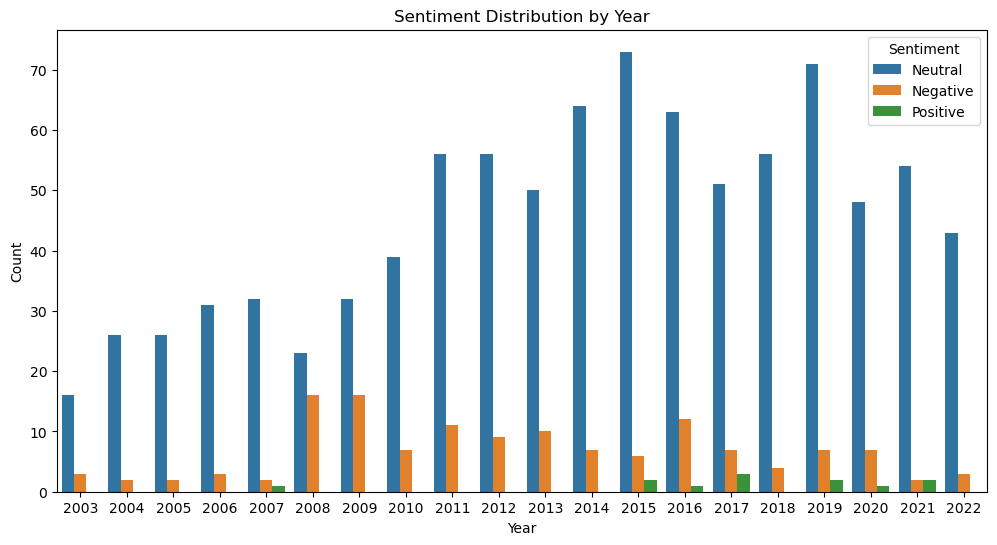

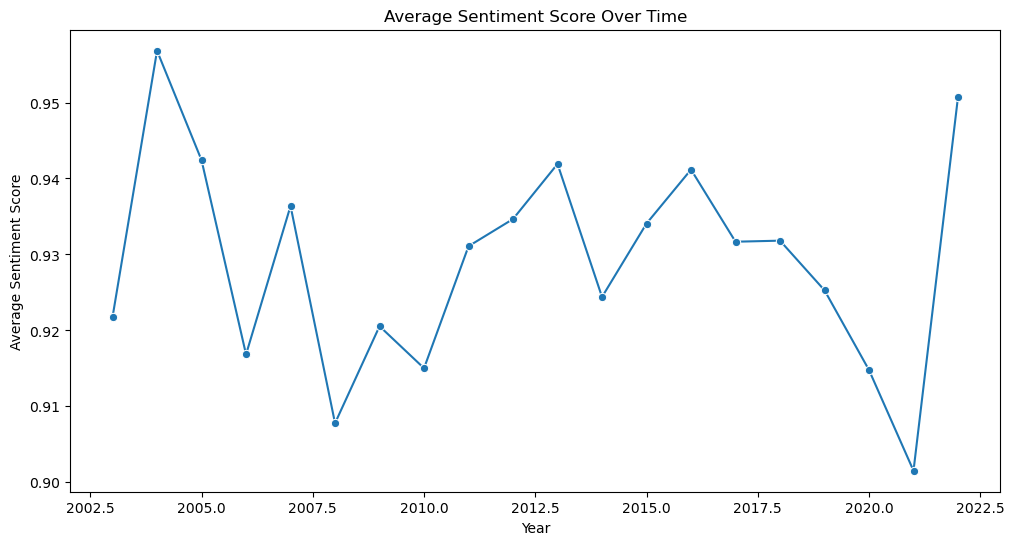

In [203]:
# Reload if needed
speeches_1 = pd.read_csv('finbert_speeches_1.csv')

# Count of sentiments per year
plt.figure(figsize=(12, 6))
sns.countplot(data=speeches_1, x='year', hue='finbert_sentiment')
plt.title('Sentiment Distribution by Year')
plt.xlabel('Year')
plt.ylabel('Count')
plt.legend(title='Sentiment')
plt.show()

# Average Sentiment Score over time

# Calculate average sentiment score by year
avg_score_by_year = speeches_1.groupby('year')['finbert_score'].mean().reset_index()

plt.figure(figsize=(12, 6))
sns.lineplot(data=avg_score_by_year, x='year', y='finbert_score', marker='o')
plt.title('Average Sentiment Score Over Time')
plt.xlabel('Year')
plt.ylabel('Average Sentiment Score')
plt.show()


In [205]:
category_percentages = speeches_1['finbert_sentiment'].value_counts(normalize=True) * 100
print(category_percentages)

finbert_sentiment
Neutral     86.011342
Negative    12.854442
Positive     1.134216
Name: proportion, dtype: float64


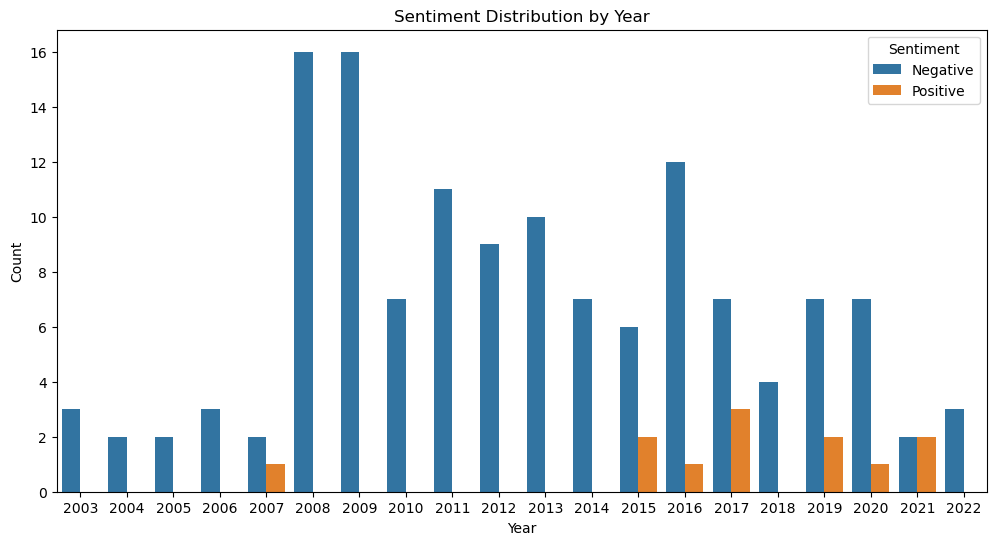

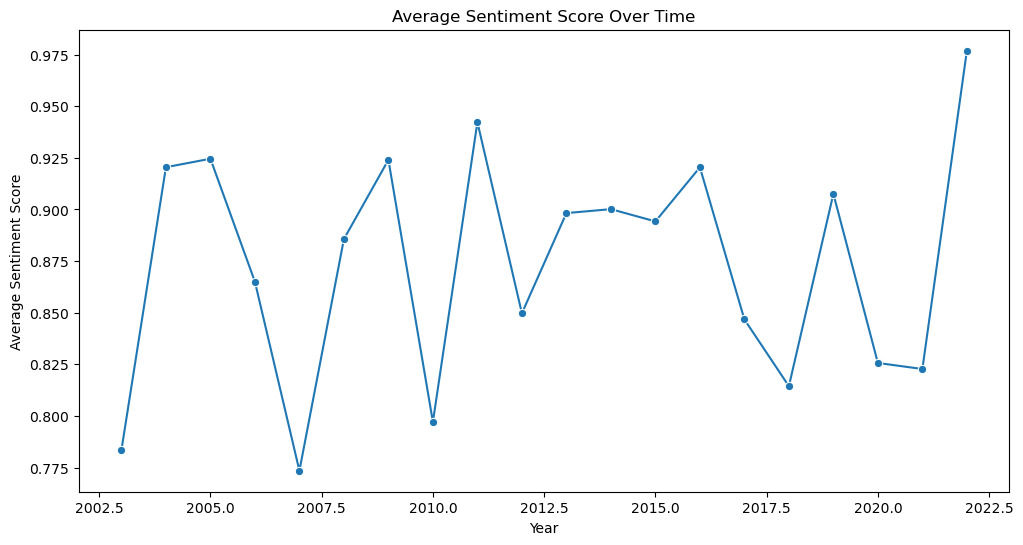

In [207]:
# Filtering out Neutral speeches
speeches_pn = speeches_1[speeches_1['finbert_sentiment'] != 'Neutral']

# Count of sentiments per year
plt.figure(figsize=(12, 6))
sns.countplot(data=speeches_pn, x='year', hue='finbert_sentiment')
plt.title('Sentiment Distribution by Year')
plt.xlabel('Year')
plt.ylabel('Count')
plt.legend(title='Sentiment')
plt.show()

# Average Sentiment Score over time

# Calculate average sentiment score by year
avg_score_by_year = speeches_pn.groupby('year')['finbert_score'].mean().reset_index()

plt.figure(figsize=(12, 6))
sns.lineplot(data=avg_score_by_year, x='year', y='finbert_score', marker='o')
plt.title('Average Sentiment Score Over Time')
plt.xlabel('Year')
plt.ylabel('Average Sentiment Score')
plt.show()


**[Table of Contents](#Table_of_contents)**

###

### II. 2nd Attempt and visualisations (FinBERT by Statements)

In [52]:
# Operate the same subsetting on original data for the second attempt

speeches = pd.read_csv('clean_speeches.csv')

# Filter speeches from 2003 onwards
speeches = speeches[speeches['year'] >= 2003].reset_index(drop=True)

# Filter speeches from each period and store in separate DataFrames
speeches2_03_07 = speeches[(speeches['year'] >= 2003) & (speeches['year'] <= 2007)].reset_index(drop=True)
speeches2_08_12 = speeches[(speeches['year'] >= 2008) & (speeches['year'] <= 2012)].reset_index(drop=True)
speeches2_13_17 = speeches[(speeches['year'] >= 2013) & (speeches['year'] <= 2017)].reset_index(drop=True)
speeches2_18_22 = speeches[(speeches['year'] >= 2018) & (speeches['year'] <= 2022)].reset_index(drop=True)

# Count of speeches in each group
count_03_07 = speeches2_03_07.shape[0] 
count_08_12 = speeches2_08_12.shape[0]
count_13_17 = speeches2_13_17.shape[0]
count_18_22 = speeches2_18_22.shape[0]

print(f"Number of speeches from 2003 to 2007: {count_03_07}")
print(f"Number of speeches from 2008 to 2012: {count_08_12}")
print(f"Number of speeches from 2013 to 2017: {count_13_17}")
print(f"Number of speeches from 2018 to 2022: {count_18_22}")

# Count speeches by year for each group
count_by_year_03_07 = speeches2_03_07['year'].value_counts().sort_index()
count_by_year_08_12 = speeches2_08_12['year'].value_counts().sort_index()
count_by_year_13_17 = speeches2_13_17['year'].value_counts().sort_index()
count_by_year_18_22 = speeches2_18_22['year'].value_counts().sort_index()

print("\nSpeeches from 2003 to 2007 by year:")
print(count_by_year_03_07)

print("\nSpeeches from 2008 to 2012 by year:")
print(count_by_year_08_12)

print("\nSpeeches from 2013 to 2017 by year:")
print(count_by_year_13_17)

print("\nSpeeches from 2018 to 2022 by year:")
print(count_by_year_18_22)


Number of speeches from 2003 to 2007: 144
Number of speeches from 2008 to 2012: 265
Number of speeches from 2013 to 2017: 349
Number of speeches from 2018 to 2022: 300

Speeches from 2003 to 2007 by year:
year
2003    19
2004    28
2005    28
2006    34
2007    35
Name: count, dtype: int64

Speeches from 2008 to 2012 by year:
year
2008    39
2009    48
2010    46
2011    67
2012    65
Name: count, dtype: int64

Speeches from 2013 to 2017 by year:
year
2013    60
2014    71
2015    81
2016    76
2017    61
Name: count, dtype: int64

Speeches from 2018 to 2022 by year:
year
2018    60
2019    80
2020    56
2021    58
2022    46
Name: count, dtype: int64


In [54]:
# Function to find and print any sentences over a specified word count threshold ##### To check!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!
def find_long_sentences(texts, threshold=512):
    long_sentences = []

    for i, text in enumerate(texts):
        # Split the text into individual sentences
        sentence_list = nltk.sent_tokenize(text)
        
        for sentence in sentence_list:
            # Calculate the word count in each sentence
            word_count = len(sentence.split())
            
            if word_count > threshold:
                # Append information about the long sentence
                long_sentences.append({
                    'reference': i,
                    'sentence': sentence,
                    'word_count': word_count
                })
    
    return long_sentences

In [56]:
# Apply to your speech data
long_sentences_03_07 = find_long_sentences(speeches2_03_07['text'], threshold=250)

# Display the results
for entry in long_sentences_03_07:
    print(f"Speech {entry['reference']} has a long sentence with {entry['word_count']} words")

Speech 128 has a long sentence with 295 words


In [58]:
# Apply to your speech data
long_sentences_08_12 = find_long_sentences(speeches2_08_12['text'], threshold=250)

# Display the results
for entry in long_sentences_08_12:
    print(f"Speech {entry['reference']} has a long sentence with {entry['word_count']} words")

In [59]:
# Apply to your speech data
long_sentences_13_17 = find_long_sentences(speeches2_13_17['text'], threshold=250)

# Display the results
for entry in long_sentences_13_17:
    print(f"Speech {entry['reference']} has a long sentence with {entry['word_count']} words")

Speech 102 has a long sentence with 284 words
Speech 205 has a long sentence with 289 words
Speech 253 has a long sentence with 256 words
Speech 273 has a long sentence with 303 words


In [62]:
# Apply to your speech data and find long sentences
long_sentences_18_22 = find_long_sentences(speeches2_18_22['text'], threshold=250)

# Display the results for reference
for entry in long_sentences_18_22:
    print(f"Speech {entry['reference']} has a long sentence with {entry['word_count']} words")

# Extract unique indices from long_sentences_18_22
long_sentence_indices = set(entry['reference'] for entry in long_sentences_18_22)

Speech 32 has a long sentence with 298 words
Speech 34 has a long sentence with 253 words
Speech 39 has a long sentence with 347 words
Speech 196 has a long sentence with 295 words
Speech 227 has a long sentence with 264 words
Speech 260 has a long sentence with 252 words
Speech 262 has a long sentence with 298 words
Speech 269 has a long sentence with 270 words
Speech 284 has a long sentence with 269 words


In [64]:
# Drop these speeches from the DataFrame
filtered_speeches = speeches2_18_22.drop(index=long_sentence_indices).reset_index(drop=True)

In [66]:
# Further subsetting
filtered_18_20 = speeches[(speeches['year'] >= 2018) & (speeches['year'] <= 2020)].reset_index(drop=True)
filtered_21_22 = speeches[(speeches['year'] >= 2021) & (speeches['year'] <= 2022)].reset_index(drop=True)

In [68]:
# Load the FinBERT model and pipeline
from transformers import AutoModelForSequenceClassification, AutoTokenizer, pipeline
from collections import Counter
from typing import List
import nltk

# Load the FinBERT model and pipeline
def load_finbert_pipeline():
    model = AutoModelForSequenceClassification.from_pretrained("yiyanghkust/finbert-tone")
    tokenizer = AutoTokenizer.from_pretrained("yiyanghkust/finbert-tone")
    return pipeline("sentiment-analysis", model=model, tokenizer=tokenizer)

finbert_pipeline = load_finbert_pipeline()

def predictor(pipe_line, sentences: List[str]):
    results = []
    
    for text in sentences:
        # Split the text into individual sentences
        sentence_list = nltk.sent_tokenize(text)
        
        # Initialize lists to store sentiment and score for each sentence
        sentence_sentiments = []
        sentence_scores = []
        
        for sentence in sentence_list:
            # Run sentiment analysis on the individual sentence
            result = pipe_line(sentence)
            label = result[0]["label"].lower()
            score = result[0]["score"]
            
            # Collect the label and score for each sentence
            sentence_sentiments.append(label)
            sentence_scores.append(score)
        
        # Aggregate by calculating majority sentiment and average score for the whole speech
        sentiment_counts = Counter(sentence_sentiments)
        majority_sentiment = sentiment_counts.most_common(1)[0][0]
        avg_score = sum(sentence_scores) / len(sentence_scores)
        
        # Append results for each speech
        results.append({
            'label': majority_sentiment,
            'score': avg_score
        })
        
    return results


In [70]:
# Apply the predictor function to each speech in your DataFrame
sentiment_results = predictor(finbert_pipeline, speeches2_03_07['text'].tolist())

# Convert results to DataFrame and add to original DataFrame as new columns
sentiment_df = pd.DataFrame(sentiment_results)
speeches2_03_07['finbert_sentiment'] = sentiment_df['label']
speeches2_03_07['finbert_score'] = sentiment_df['score']

# Save the result
speeches2_03_07.to_csv('finbert2_speeches_03_07.csv', index=False)

# Display the updated DataFrame
print(speeches2_03_07[['reference', 'date', 'author', 'text', 'year', 'finbert_sentiment', 'finbert_score']])


        reference        date     author  \
0    r030120a_BOE  2003-01-20     george   
1    r030129a_BOE  2003-01-29       bean   
2    r030218a_BOE  2003-02-18     barker   
3    r030313a_BOE  2003-03-13      large   
4    r030324a_BOE  2003-03-24     george   
..            ...         ...        ...   
139  r071031a_BOE  2007-10-31       bean   
140  r071112a_BOE  2007-11-12  jenkinson   
141  r071122a_BOE  2007-11-22      lomax   
142  r071127a_BOE  2007-11-27   sentance   
143  r071213a_BOE  2007-12-13     tucker   

                                                  text  year  \
0    May I begin, Mr President, by thanking you and...  2003   
1    Good evening. It is a great pleasure to be her...  2003   
2    One of the significant factors in economic deb...  2003   
3    Welcome to all present - particularly Bill Rut...  2003   
4    I must confess that I was surprised when I dis...  2003   
..                                                 ...   ...   
139  We also know there

In [71]:
# Apply the predictor function to each speech in your DataFrame
sentiment_results = predictor(finbert_pipeline, speeches2_08_12['text'].tolist())

# Convert results to DataFrame and add to original DataFrame as new columns
sentiment_df = pd.DataFrame(sentiment_results)
speeches2_08_12['finbert_sentiment'] = sentiment_df['label']
speeches2_08_12['finbert_score'] = sentiment_df['score']

# Save the result
speeches2_08_12.to_csv('finbert2_speeches_08_12.csv', index=False)

# Display the updated DataFrame
print(speeches2_08_12[['reference', 'date', 'author', 'text', 'year', 'finbert_sentiment', 'finbert_score']])

        reference        date    author  \
0    r080117a_BOE  2008-01-17     gieve   
1    r080122a_BOE  2008-01-22       cbi   
2    r080218a_BOE  2008-02-18    besley   
3    r080219a_BOE  2008-02-19   no_info   
4    r080221a_BOE  2008-02-21  sentance   
..            ...         ...       ...   
260  r121113a_BOE  2012-11-13     cohrs   
261  r121121a_BOE  2012-11-21     weale   
262  r121212a_BOE  2012-12-12      dale   
263  r121214a_BOE  2012-12-14     weale   
264  r121220a_BOE  2012-12-20   jenkins   

                                                  text  year  \
0    These are testing times for the MPC. The lates...  2008   
1    It is four months since Northern Rock came to ...  2008   
2    Ladies and Gentlemen, thank you for coming. It...  2008   
3    Good evening. It is a great pleasure for me to...  2008   
4    Good afternoon, ladies and gentlemen. I am del...  2008   
..                                                 ...   ...   
260  All speeches are available onl

In [72]:
# Apply the predictor function to each speech in your DataFrame
sentiment_results = predictor(finbert_pipeline, speeches2_13_17['text'].tolist())

# Convert results to DataFrame and add to original DataFrame as new columns
sentiment_df = pd.DataFrame(sentiment_results)
speeches2_13_17['finbert_sentiment'] = sentiment_df['label']
speeches2_13_17['finbert_score'] = sentiment_df['score']

# Save the result
speeches2_13_17.to_csv('finbert2_speeches_13_17.csv', index=False)

# Display the updated DataFrame
print(speeches2_13_17[['reference', 'date', 'author', 'text', 'year', 'finbert_sentiment', 'finbert_score']])


        reference        date      author  \
0    r130114a_BOE  2013-01-14      tucker   
1    r130118a_BOE  2013-01-18  mccafferty   
2    r130122a_BOE  2013-01-22        king   
3    r130124a_BOE  2013-01-24     no_info   
4    r130211a_BOE  2013-02-11      bailey   
..            ...         ...         ...   
344  r171127a_BOE  2017-11-27     haldane   
345  r171129a_BOE  2017-11-29      carney   
346  r171130a_BOE  2017-11-30       sharp   
347  r171207a_BOE  2017-12-07      gracie   
348  r171220a_BOE  2017-12-20      hauser   

                                                  text  year  \
0    The accusation was that mainstream models had ...  2013   
1    All speeches are available online at One of th...  2013   
2    I am delighted to be in Belfast to deliver my ...  2013   
3    All speeches are available online at Thank you...  2013   
4    Thank you for inviting me to give this Nichola...  2013   
..                                                 ...   ...   
344  Terrib

In [ ]:
# Apply the predictor function to each speech in your DataFrame
# sentiment_results = predictor(finbert_pipeline, filtered_18_20['text'].tolist())

# Convert results to DataFrame and add to original DataFrame as new columns
# sentiment_df = pd.DataFrame(sentiment_results)
# filtered_18_20['finbert_sentiment'] = sentiment_df['label']
# filtered_18_20['finbert_score'] = sentiment_df['score']

# Display the updated DataFrame
# print(filtered_18_20[['reference', 'date', 'author', 'text', 'year', 'finbert_sentiment', 'finbert_score']])

# filtered_18_20.to_csv('finbert2_speeches_18_20.csv', index=False)

In [ ]:
# Apply the predictor function to each speech in your DataFrame
# sentiment_results = predictor(finbert_pipeline, filtered_21_22['text'].tolist())

# Convert results to DataFrame and add to original DataFrame as new columns
# sentiment_df = pd.DataFrame(sentiment_results)
# filtered_21_22['finbert_sentiment'] = sentiment_df['label']
# filtered_21_22['finbert_score'] = sentiment_df['score']

# Display the updated DataFrame
# print(filtered_21_22[['reference', 'date', 'author', 'text', 'year', 'finbert_sentiment', 'finbert_score']])

# filtered_21_22.to_csv('finbert2_speeches_21_22.csv', index=False)

In [76]:
# Adjust the function so it bypasses the last two subsets errors.
def load_finbert_pipeline():
    model = AutoModelForSequenceClassification.from_pretrained("yiyanghkust/finbert-tone")
    tokenizer = AutoTokenizer.from_pretrained("yiyanghkust/finbert-tone")
    return pipeline("sentiment-analysis", model=model, tokenizer=tokenizer)

finbert_pipeline = load_finbert_pipeline()

# Predictor function with sentence splitting and token length handling
def predictor(pipe_line, sentences: List[str], max_length=512):
    results = []
    tokenizer = AutoTokenizer.from_pretrained("yiyanghkust/finbert-tone")
    
    for text in sentences:
        # Split the text into individual sentences
        sentence_list = nltk.sent_tokenize(text)
        
        # Initialize lists to store sentiment and score for each sentence
        sentence_sentiments = []
        sentence_scores = []
        
        for sentence in sentence_list:
            # Tokenize sentence and check token length
            tokens = tokenizer.encode(sentence, add_special_tokens=True)
            
            # If token length exceeds max_length, split further
            if len(tokens) > max_length:
                # We could split long sentences into parts that fit within the max length
                # Use a simple approach to split by spaces while keeping the parts under max_length tokens
                split_tokens = [tokens[i:i+max_length] for i in range(0, len(tokens), max_length)]
                for part_tokens in split_tokens:
                    part_sentence = tokenizer.decode(part_tokens, skip_special_tokens=True)
                    try:
                        # Run sentiment analysis on the part of the sentence
                        result = pipe_line(part_sentence)
                        label = result[0]["label"].lower()
                        score = result[0]["score"]
                        
                        # Collect the label and score for each sentence part
                        sentence_sentiments.append(label)
                        sentence_scores.append(score)
                    except Exception as e:
                        print(f"Error processing part of sentence: {part_sentence}")
                        print(f"Exception: {e}")
                        continue
            else:
                # If the sentence fits within the token limit, process it directly
                try:
                    result = pipe_line(sentence)
                    label = result[0]["label"].lower()
                    score = result[0]["score"]
                    
                    # Collect the label and score for the sentence
                    sentence_sentiments.append(label)
                    sentence_scores.append(score)
                except Exception as e:
                    print(f"Error processing sentence: {sentence}")
                    print(f"Exception: {e}")
                    continue
        
        # Aggregate by calculating majority sentiment and average score for the whole speech
        sentiment_counts = Counter(sentence_sentiments)
        majority_sentiment = sentiment_counts.most_common(1)[0][0] if sentence_sentiments else "neutral"
        avg_score = sum(sentence_scores) / len(sentence_scores) if sentence_scores else 0.0
        
        # Append results for each speech
        results.append({
            'label': majority_sentiment,
            'score': avg_score
        })
        
    return results


In [78]:
# Apply the predictor function to each speech in filtered_18_20
sentiment_results_18_20 = predictor(finbert_pipeline, filtered_18_20['text'].tolist())

# Convert the results to DataFrames and add the results back to the original DataFrames
sentiment_df_18_20 = pd.DataFrame(sentiment_results_18_20)

# Add the sentiment results to the original DataFrames
filtered_18_20 = pd.concat([filtered_18_20, sentiment_df_18_20], axis=1)

# View the updated DataFrames
print(filtered_18_20.head())

filtered_18_20.to_csv('finbert2_speeches_18_20.csv', index=False)

Error processing part of sentence: principles for operational resilience...................................................................................................................................... 1 an evolving operational risk landscape...................................................................................................................... 2 essential elements of operational resilience............................................................................................................. 2 definition of operational resilience.............................................................................................................................. 3 operational resilience
Exception: The size of tensor a (513) must match the size of tensor b (512) at non-singleton dimension 1
Error processing part of sentence: principles................................................................................................................................... 4 oper

In [80]:
# Apply the predictor function to each speech in filtered_21_22
sentiment_results_21_22 = predictor(finbert_pipeline, filtered_21_22['text'].tolist())

# Convert the results to DataFrames and add the results back to the original DataFrames
sentiment_df_21_22 = pd.DataFrame(sentiment_results_21_22)

# Add the sentiment results to the original DataFrames
filtered_21_22 = pd.concat([filtered_21_22, sentiment_df_21_22], axis=1)

# View the updated DataFrames
print(filtered_21_22.head())

filtered_21_22.to_csv('finbert2_speeches_21_22.csv', index=False)


Error processing part of sentence: benefits from reduced costs associated with banking crises................................. 8 the frequency of banking crises................................................................. 8 the economic costs of banking crises........................................................ 9 the expected benefits from reducing the frequency of banking crises.... 12 the impact of capital and liquidity requirements on the probability of crises.................................................................................................... 14 the impact of capital and liquidity requirements on the severity of crises.................................................................................................... 17 economic benefits from reducing the volatility of output...................................... 18 changes in lending spreads.....................................
Exception: The size of tensor a (513) must match the size of tensor b (512) at no

In [88]:
# If needed reload the resulting datasets
# speeches2_03_07 = pd.read_csv('finbert2_speeches_03_07.csv')
# speeches2_08_12 = pd.read_csv('finbert2_speeches_08_12.csv')
# speeches2_13_17 = pd.read_csv('finbert2_speeches_13_17.csv')

# Rename columns for merging
speeches2_03_07 = speeches2_03_07.rename(columns={'finbert_sentiment': 'label', 'finbert_score': 'score'})
speeches2_08_12 = speeches2_08_12.rename(columns={'finbert_sentiment': 'label', 'finbert_score': 'score'})
speeches2_13_17 = speeches2_13_17.rename(columns={'finbert_sentiment': 'label', 'finbert_score': 'score'})


In [90]:
# Concatenate all groups into one DataFrame for overall analysis
speeches_2 = pd.concat([speeches2_03_07, speeches2_08_12, speeches2_13_17, filtered_18_20, filtered_21_22])

speeches_2.to_csv('finbert_speeches_2.csv', index=False)

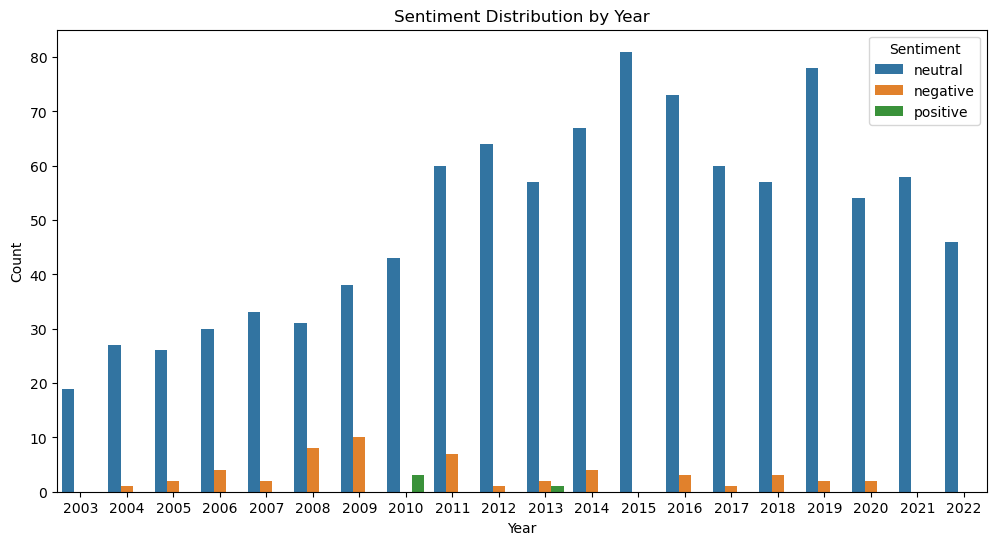

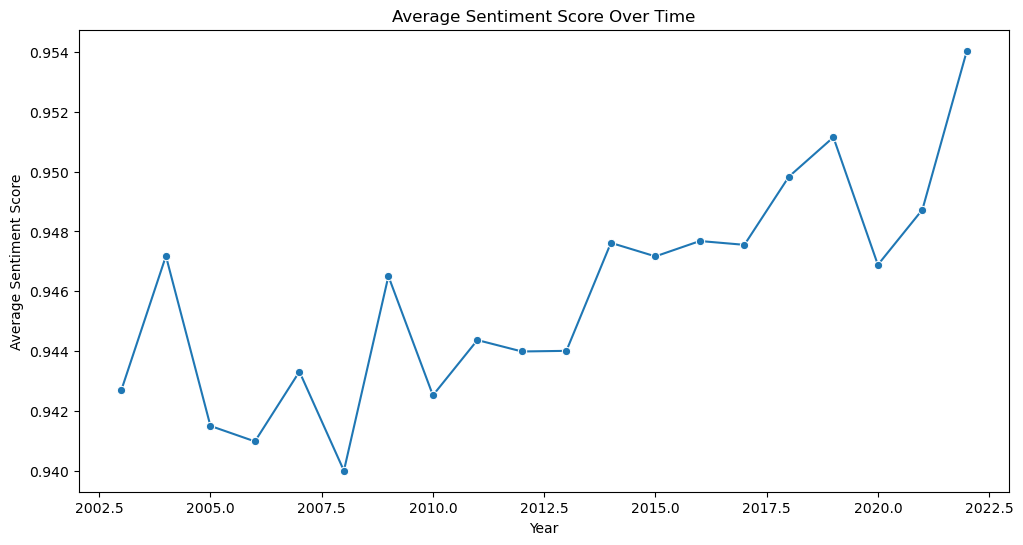

In [94]:
# If needed reload the resulting dataset
# speeches_2 = pd.read_csv('finbert_speeches_2.csv')

# Count of sentiments per year
plt.figure(figsize=(12, 6))
sns.countplot(data=speeches_2, x='year', hue='label')
plt.title('Sentiment Distribution by Year')
plt.xlabel('Year')
plt.ylabel('Count')
plt.legend(title='Sentiment')
plt.show()

# Average Sentiment Score over time

# Calculate average sentiment score by year
avg_score_by_year = speeches_2.groupby('year')['score'].mean().reset_index()

plt.figure(figsize=(12, 6))
sns.lineplot(data=avg_score_by_year, x='year', y='score', marker='o')
plt.title('Average Sentiment Score Over Time')
plt.xlabel('Year')
plt.ylabel('Average Sentiment Score')
plt.show()


In [98]:
category_percentages = speeches_2['label'].value_counts(normalize=True) * 100
print(category_percentages)

label
neutral     94.706994
negative     4.914934
positive     0.378072
Name: proportion, dtype: float64



**The distribution of FinBERT sentiment scores reveals distinct patterns between the two approaches.**

- In the **512 Tokens Truncation** method: Neutral sentiment is 86%, Negative sentiment is 12.9%, and Positive sentiment is 1.1%.
  
- In the **Statement-by-Statement** approach: Neutral sentiment increases to 94.7%, Negative sentiment drops to 4.9%, and Positive  sentiment further decreases to 0.4%.

These differences suggest that the **512 Tokens Truncation** approach captures a broader range of sentiment, with more instances of both positive and negative tones. In contrast, the **Statement-by-Statement** method leans heavily toward neutrality, likely due to each statement’s narrower context, which reduces the likelihood of strong sentiment. This could indicate that analysing entire segments captures more sentiment nuance, while isolated statements may dilute the emotional tone.


**[Table of Contents](#Table_of_contents)**

###

### III. Visualisations

In [17]:
# If needed realod the dataset
speeches = pd.read_csv('finbert_speeches_1.csv')
speeches.head()

,reference,date,author,is_gov,text,year,text_length,finbert_sentiment,finbert_score
0,r030120a_BOE,2003-01-20,george,False,"May I begin, Mr President, by thanking you and...",2003,11757,Neutral,0.996209
1,r030129a_BOE,2003-01-29,bean,False,Good evening. It is a great pleasure to be her...,2003,30848,Neutral,0.971784
2,r030218a_BOE,2003-02-18,barker,False,One of the significant factors in economic deb...,2003,40668,Negative,0.754248
3,r030313a_BOE,2003-03-13,large,False,Welcome to all present - particularly Bill Rut...,2003,14338,Neutral,0.994006
4,r030324a_BOE,2003-03-24,george,False,I must confess that I was surprised when I dis...,2003,10622,Neutral,0.993341


In [19]:
def visualize_trend_over_time(df, time_col, value_cols, aggregation='mean', rolling_window=7, file_name=None):
    """
    Visualizes trends over time for the given DataFrame.
    """
    try:
        print(f"Visualizing trends for {file_name if file_name else 'Data'}")
        
        # Ensure the time column is datetime type
        if not pd.api.types.is_datetime64_any_dtype(df[time_col]):
            df[time_col] = pd.to_datetime(df[time_col], errors='coerce')

        # Remove rows where time_col is NaT (Not a Timestamp)
        df = df.dropna(subset=[time_col])

        # Step 1: Plot raw trends over time
        plt.figure(figsize=(12, 6))
        for col in value_cols:
            plt.plot(df[time_col], df[col], label=f'Raw {col}', alpha=0.7)
        
        plt.title(f'Trends Over Time - Raw Data')
        plt.xlabel('Time')
        plt.ylabel('Values')
        plt.legend()
        plt.grid(True)
        plt.tight_layout()
        plt.show()

        # Step 2: Plot Rolling Averages
        plt.figure(figsize=(12, 6))
        for col in value_cols:
            rolling_col = df[col].rolling(window=rolling_window).mean()
            plt.plot(df[time_col], rolling_col, label=f'Rolling Avg {col}', alpha=0.8)

        plt.title(f'Trends Over Time - {rolling_window}-Day Rolling Averages')
        plt.xlabel('Time')
        plt.ylabel('Values')
        plt.legend()
        plt.grid(True)
        plt.tight_layout()
        plt.show()

        # Step 3: Aggregated view (optional, based on user-specified aggregation)
        df_aggregated = df.set_index(time_col).resample('M').agg(aggregation)  # Resample to monthly
        plt.figure(figsize=(12, 6))
        for col in value_cols:
            plt.plot(df_aggregated.index, df_aggregated[col], label=f'{aggregation.capitalize()} {col}', marker='o')
        
        plt.title(f'{aggregation.capitalize()} Values Over Time (Aggregated Monthly)')
        plt.xlabel('Time')
        plt.ylabel(f'{aggregation.capitalize()} Values')
        plt.legend()
        plt.grid(True)
        plt.tight_layout()
        plt.show()

        print(f"Visualization complete for {file_name if file_name else 'Data'}")

    except Exception as e:
        print(f"An error occurred: {e}")


Visualizing trends for Tone of the Speeches


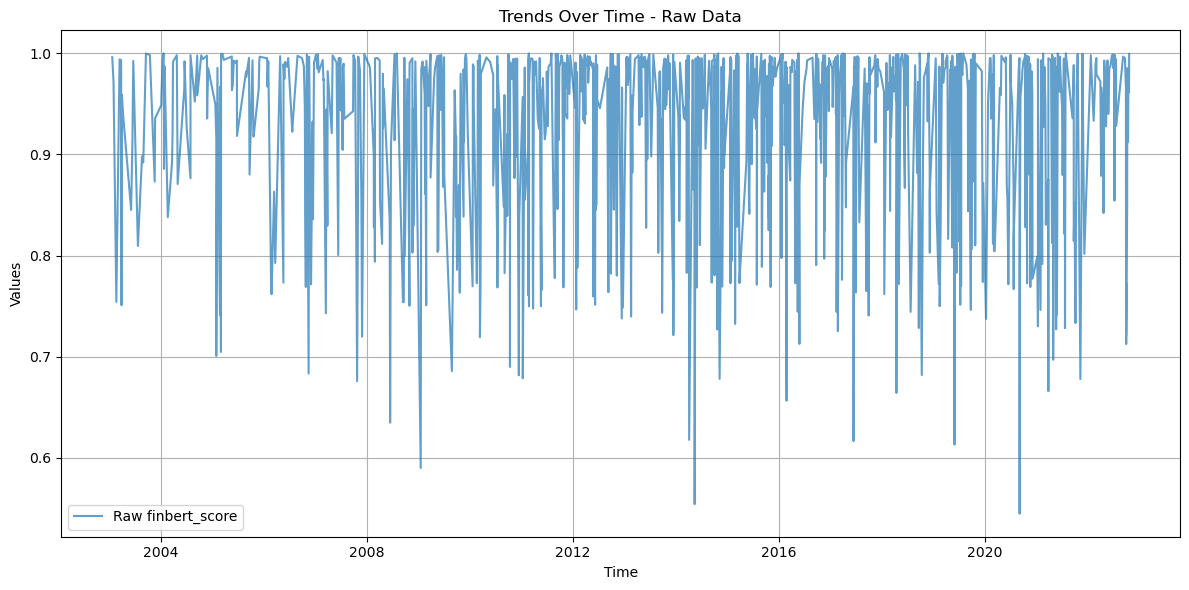

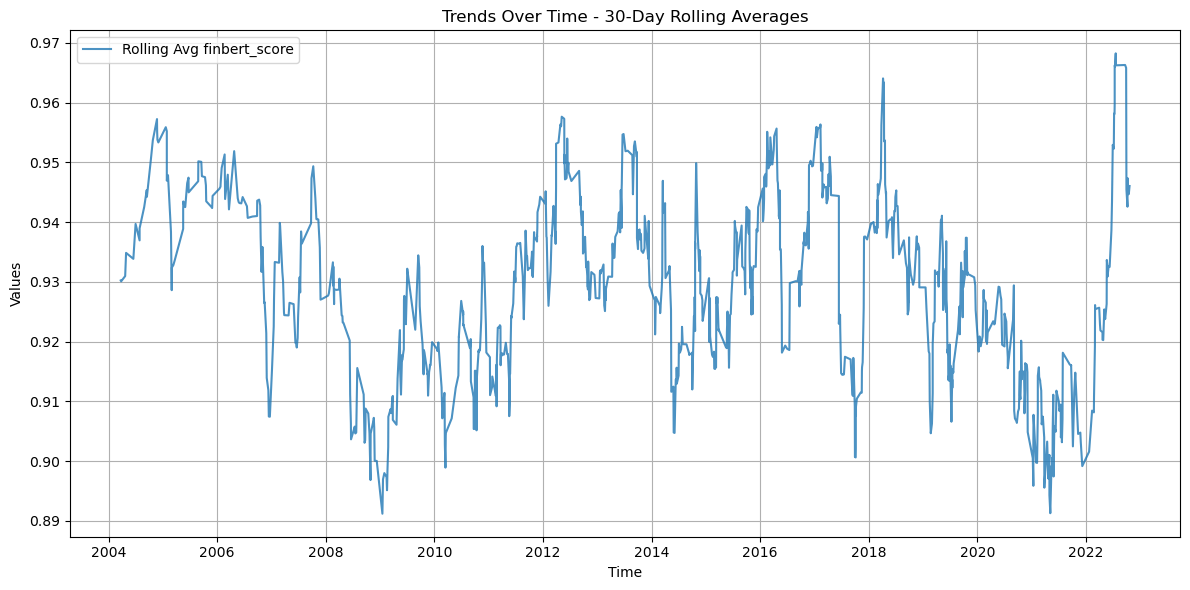

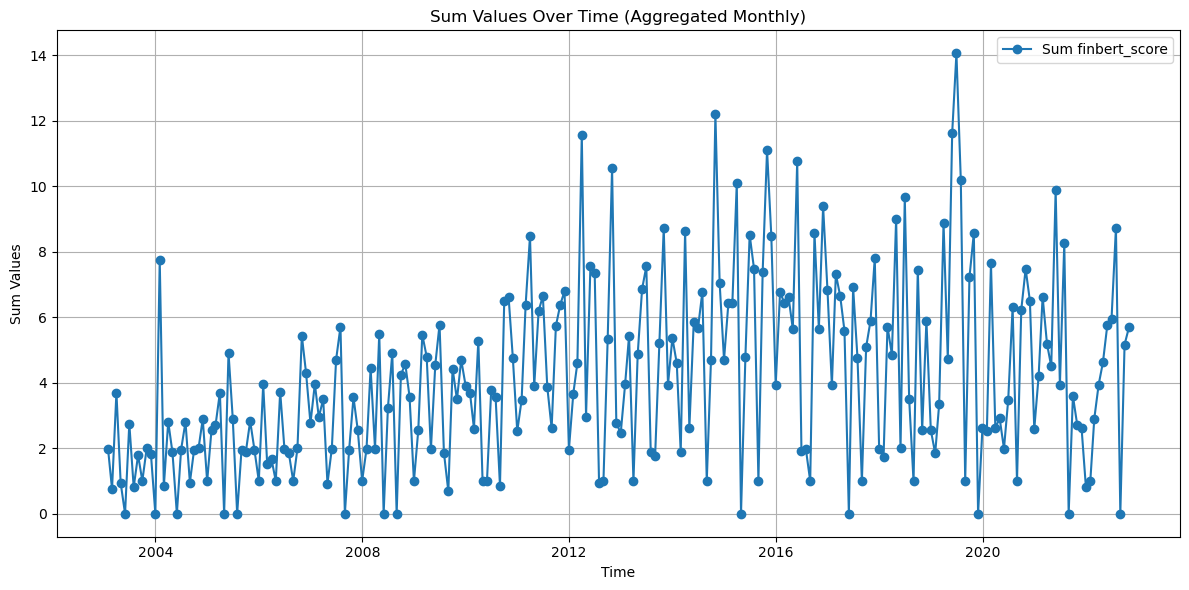

Visualization complete for Tone of the Speeches


In [21]:
# Apply the function
visualize_trend_over_time(speeches, time_col='date', value_cols=['finbert_score'], aggregation='sum', rolling_window=30, file_name="Tone of the Speeches")


In [23]:
# Distribution of FinBERT Sentiment Categories (finbert_sentiment)
print(f"Distribution of FinBERT Sentiment Categories")
print(speeches['finbert_sentiment'].value_counts())

# Distribution of FinBERT Scores (finbert_score)
print(f"\nDistribution of FinBERT Scores (finbert_score)")
speeches['finbert_score'].describe()

# Score binning
# merged_df['finbert_score_bin'] = pd.qcut(merged_df['finbert_score'], q=3, labels=['Low', 'Medium', 'High'])

Distribution of FinBERT Sentiment Categories
finbert_sentiment
Neutral     910
Negative    136
Positive     12
Name: count, dtype: int64

Distribution of FinBERT Scores (finbert_score)


count    1058.000000
mean        0.928928
std         0.086649
min         0.544851
25%         0.891673
50%         0.968705
75%         0.992746
max         0.999993
Name: finbert_score, dtype: float64

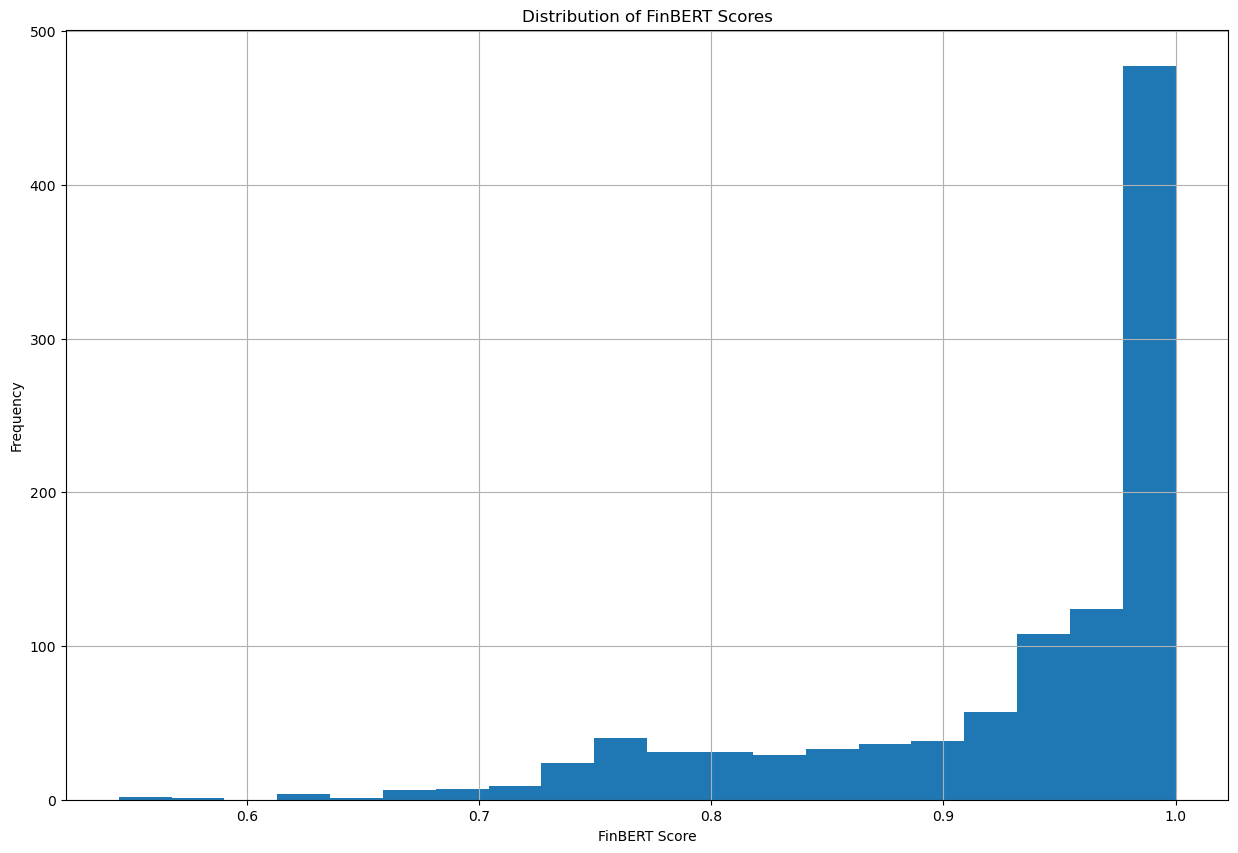

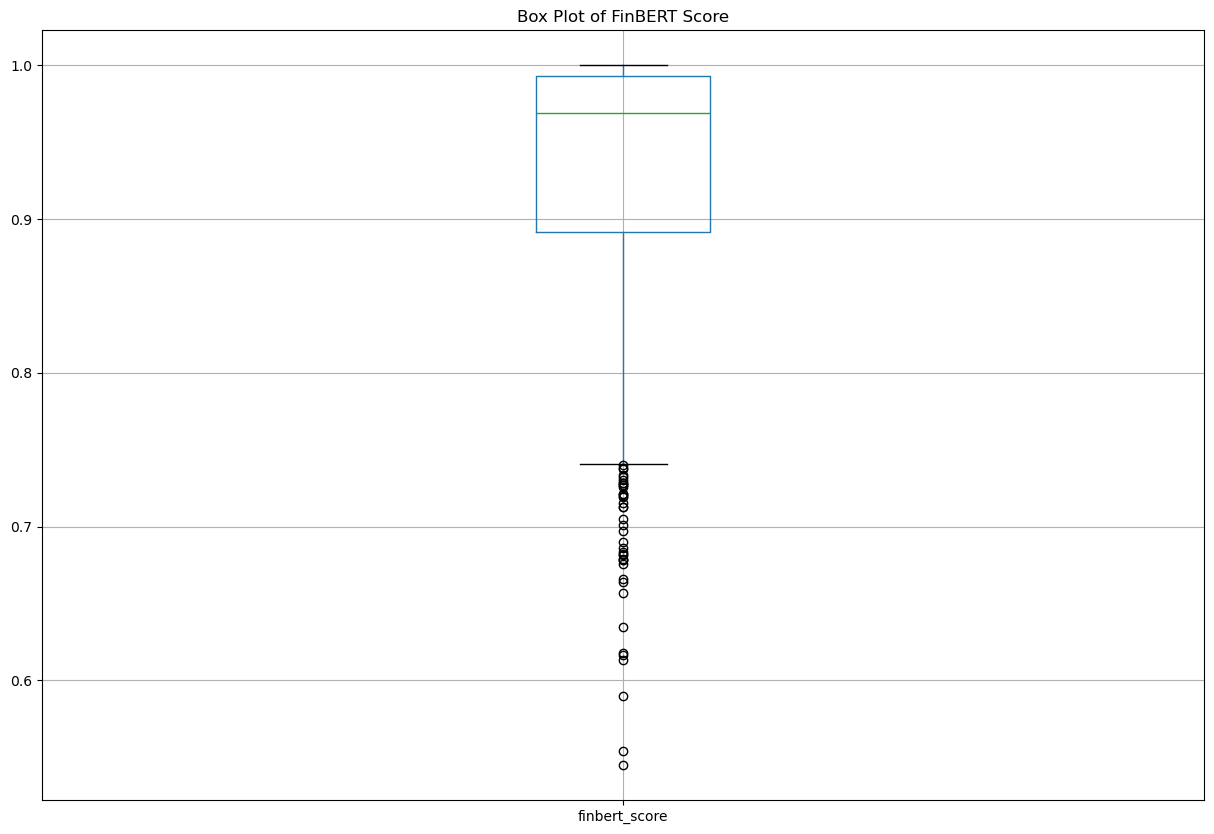

In [25]:
# Visualise Sentiment and Score distribution
speeches['finbert_score'].hist(bins=20)
plt.xlabel('FinBERT Score')
plt.ylabel('Frequency')
plt.title('Distribution of FinBERT Scores')
plt.show()

# Box plot for outliers
speeches.boxplot(column='finbert_score')
plt.title('Box Plot of FinBERT Score')
plt.show()


**[Table of Contents](#Table_of_contents)**

#

<a id="Correlation_Analysis:_OLS_Regression"></a>
# 3. Correlation Analysis: OLS Regression

<a id="DataFrames_Merge"></a>
## 3.0 DataFrames Merge

In [36]:
# List of DataFrames to process
df_list = [speeches, economic_indicators ]
df_names = ['speeches', 'economic_indicators']

# Process each DataFrame
for df, name in zip(df_list, df_names):
    print(f"\nProcessing DataFrame: {name}")
    process_dataframe(df, show_description=True)


Processing DataFrame: speeches
First 5 rows of the DataFrame:
      reference       date  author  is_gov  \
0  r030120a_BOE 2003-01-20  george   False   
1  r030129a_BOE 2003-01-29    bean   False   
2  r030218a_BOE 2003-02-18  barker   False   
3  r030313a_BOE 2003-03-13   large   False   
4  r030324a_BOE 2003-03-24  george   False   

                                                text  year  text_length  \
0  May I begin, Mr President, by thanking you and...  2003        11757   
1  Good evening. It is a great pleasure to be her...  2003        30848   
2  One of the significant factors in economic deb...  2003        40668   
3  Welcome to all present - particularly Bill Rut...  2003        14338   
4  I must confess that I was surprised when I dis...  2003        10622   

  finbert_sentiment  finbert_score  
0           Neutral       0.996209  
1           Neutral       0.971784  
2          Negative       0.754248  
3           Neutral       0.994006  
4           Neutral     

In [38]:
# List of indicator columns to use
indicator_columns = ['finbert_score', 'gdp_rate', 'cpi_rate', 'unemployment_rate', 'weekly_earning_rate', 'redundancies', 
                     'bank_rate', 'gilt_purchases_bn', 'bond_purchases', 'asset_purchase_decisions']

# Convert the date columns to datetime format
speeches['date'] = pd.to_datetime(speeches['date'])
economic_indicators['date'] = pd.to_datetime(economic_indicators['date'])

# Drop rows with null values in the 'date' column in economic_indicators
economic_indicators = economic_indicators.dropna(subset=['date'])

# Perform the asof merge
merged_df = pd.merge_asof(
    speeches.sort_values('date'),  # Sort speeches by date
    economic_indicators.sort_values('date'),  # Sort economic data by date
    on='date',  # Join on date
    direction='nearest',  # Nearest matching date
    tolerance=pd.Timedelta('30D')  # or another suitable time window
)

# Fill NaNs in indicator columns with a moving average (3-month window)
for column in indicator_columns:
    merged_df[column].fillna(merged_df[column].rolling(window=3, min_periods=1).mean(), inplace=True)

# Dropping unnecessary columns
merged_df = merged_df.drop(columns=['is_gov', 'text', 'gdp', 'cpi', 'weekly_earning','redundancies_rate_change'])

# Check the resulting column names
print(f"\nResulting DF's columns:")
print(merged_df.columns)

merged_df.head()



Resulting DF's columns:
Index(['reference', 'date', 'author', 'year', 'text_length',
       'finbert_sentiment', 'finbert_score', 'gdp_rate', 'cpi_rate',
       'unemployment_rate', 'unemployment_rate_change', 'weekly_earning_rate',
       'redundancies', 'bank_rate', 'gilt_purchases_bn', 'bond_purchases',
       'asset_purchase_decisions'],
      dtype='object')


,reference,date,author,year,text_length,finbert_sentiment,finbert_score,gdp_rate,cpi_rate,unemployment_rate,unemployment_rate_change,weekly_earning_rate,redundancies,bank_rate,gilt_purchases_bn,bond_purchases,asset_purchase_decisions
0,r030120a_BOE,2003-01-20,george,2003,11757,Neutral,0.996209,0.004033,0.003587,5.127928,0.023931,0.004170,185204.0,0.0400,0.0,0.0,0.0
1,r030129a_BOE,2003-01-29,bean,2003,30848,Neutral,0.971784,0.004033,0.003587,5.127928,0.023931,0.004170,185204.0,0.0400,0.0,0.0,0.0
2,r030218a_BOE,2003-02-18,barker,2003,40668,Negative,0.754248,-0.002150,0.003547,5.166501,0.007522,0.013887,179137.0,0.0375,0.0,0.0,0.0
3,r030313a_BOE,2003-03-13,large,2003,14338,Neutral,0.994006,-0.002150,0.003547,5.166501,0.007522,0.013887,179137.0,0.0375,0.0,0.0,0.0
4,r030324a_BOE,2003-03-24,george,2003,10622,Neutral,0.993341,0.009420,0.003282,5.116309,-0.009715,-0.002546,176542.0,0.0375,0.0,0.0,0.0


In [40]:
# Check for missing and infinite values
missing_values = merged_df.isnull().sum()
print("Missing Values:\n", missing_values)

infinite_values = merged_df.isin([np.inf, -np.inf]).sum()
print("\nInfinite Values:\n", infinite_values)

# Clean the DataFrame
merged_df.replace([np.inf, -np.inf], np.nan, inplace=True)  # Replace inf with NaN
merged_df.dropna(inplace=True)  # Drop rows with NaN in x_columns


Missing Values:
 reference                   0
date                        0
author                      0
year                        0
text_length                 0
finbert_sentiment           0
finbert_score               0
gdp_rate                    0
cpi_rate                    0
unemployment_rate           0
unemployment_rate_change    0
weekly_earning_rate         0
redundancies                0
bank_rate                   0
gilt_purchases_bn           0
bond_purchases              0
asset_purchase_decisions    0
dtype: int64

Infinite Values:
 reference                   0
date                        0
author                      0
year                        0
text_length                 0
finbert_sentiment           0
finbert_score               0
gdp_rate                    0
cpi_rate                    0
unemployment_rate           0
unemployment_rate_change    0
weekly_earning_rate         0
redundancies                0
bank_rate                   0
gilt_purchases_bn    

In [42]:
# Save the resulting merged DataFrame
# save_results(merged_df, file_path)

merged_df.to_csv('merged_df.csv', index=False)

Visualizing trends for economic_indicators


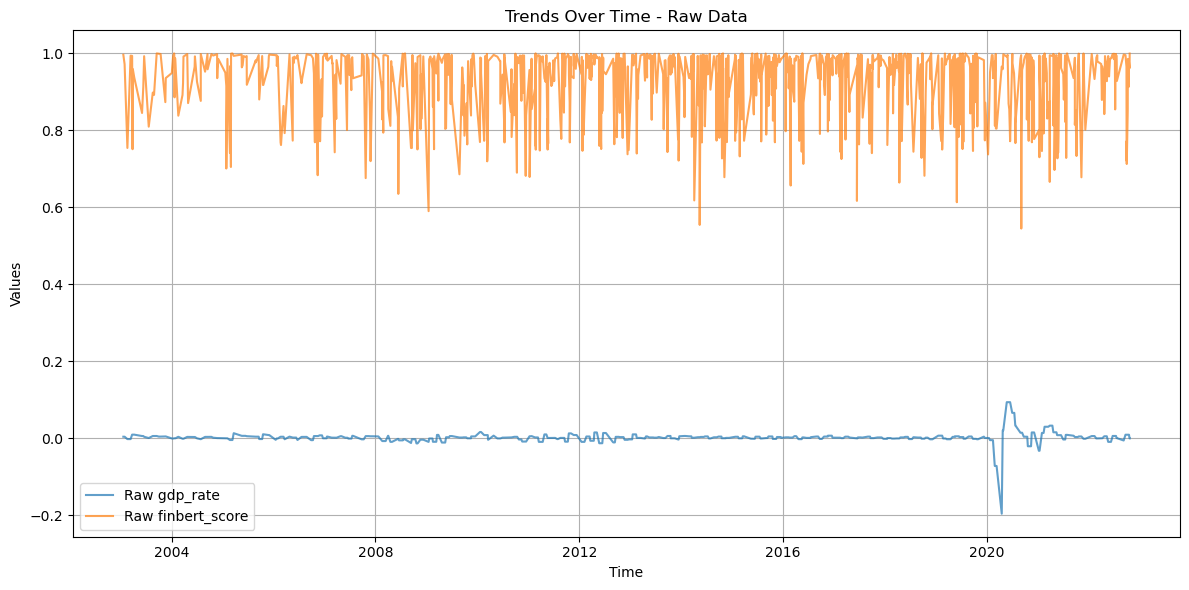

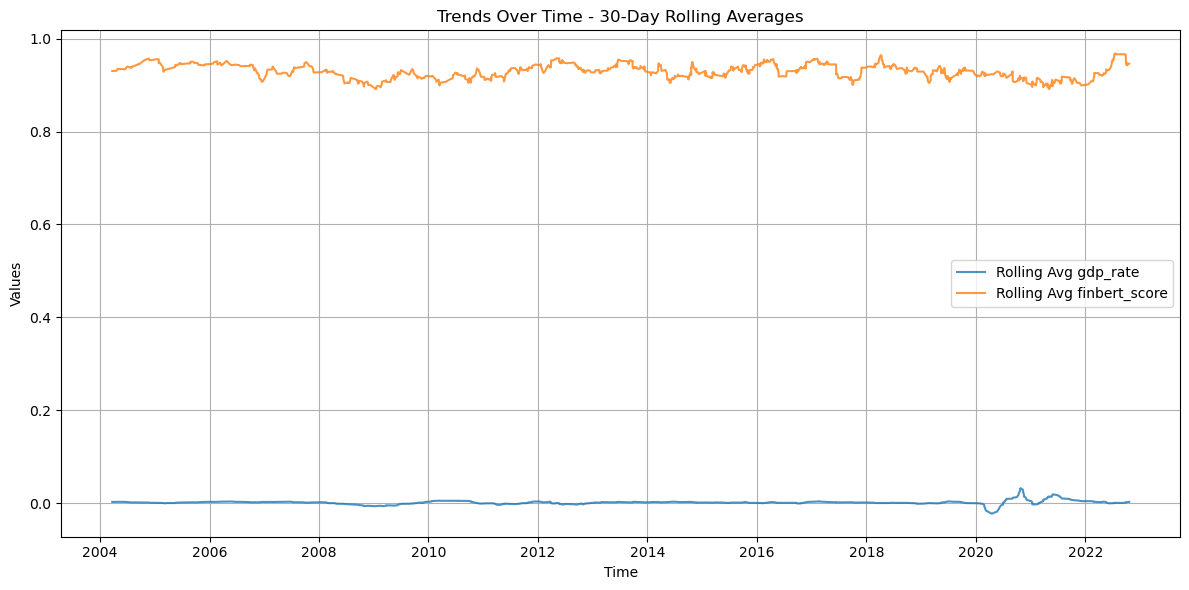

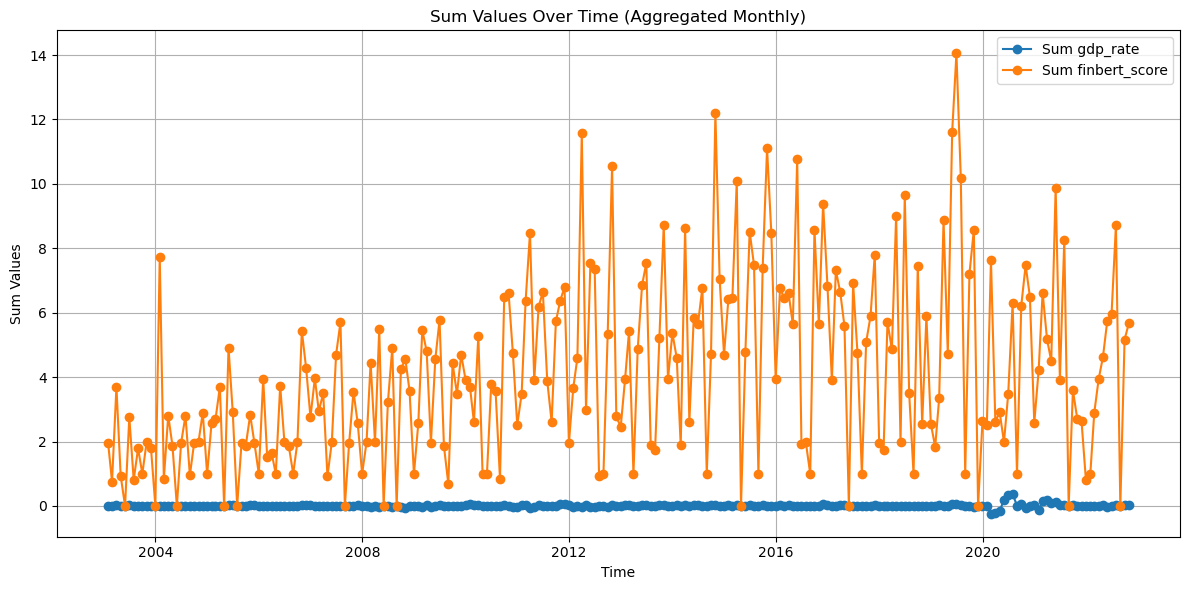

Visualization complete for economic_indicators
Visualizing trends for economic_indicators


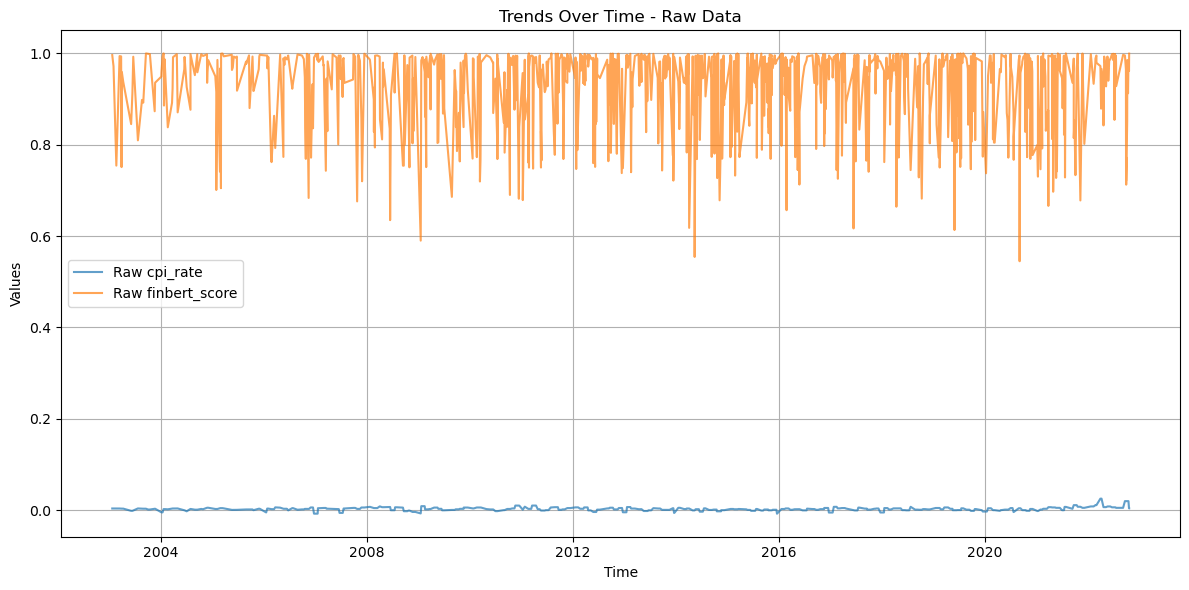

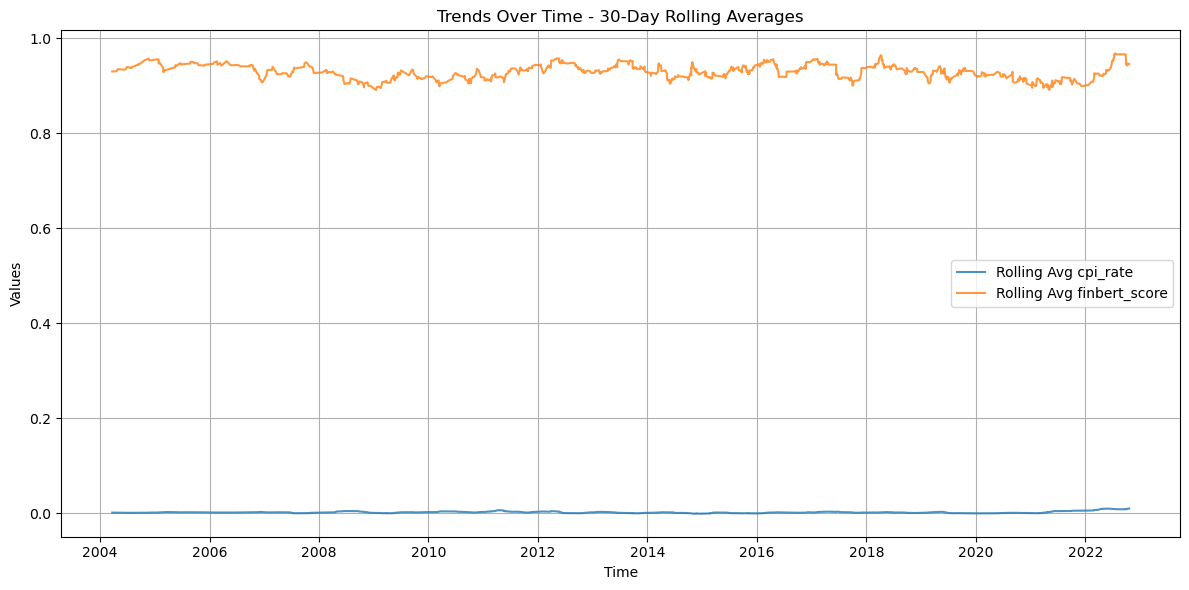

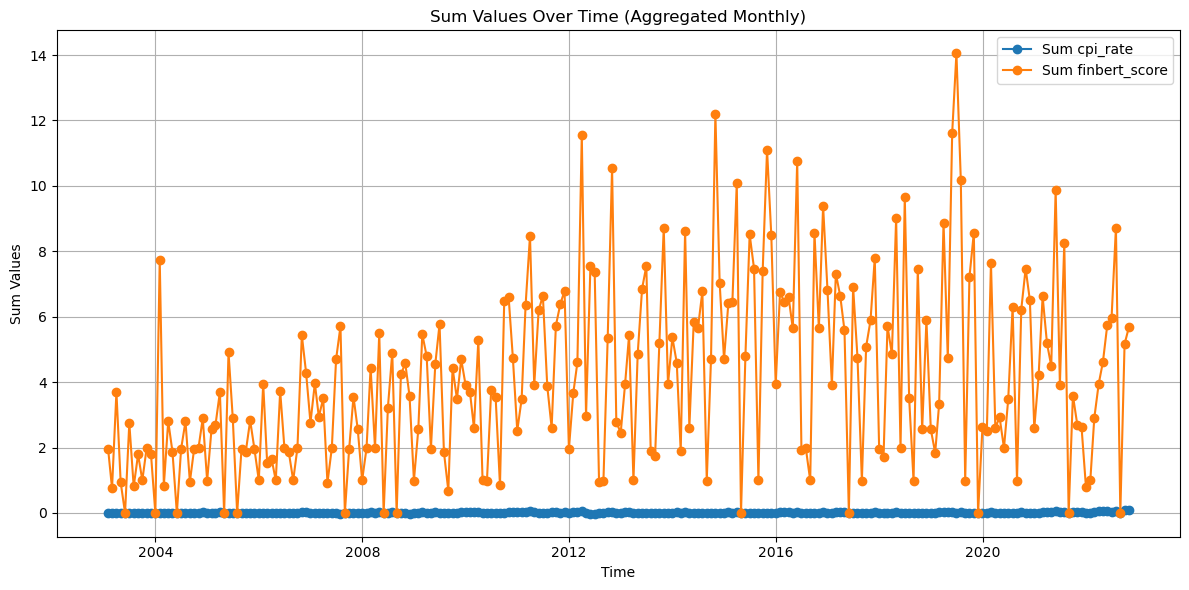

Visualization complete for economic_indicators
Visualizing trends for economic_indicators


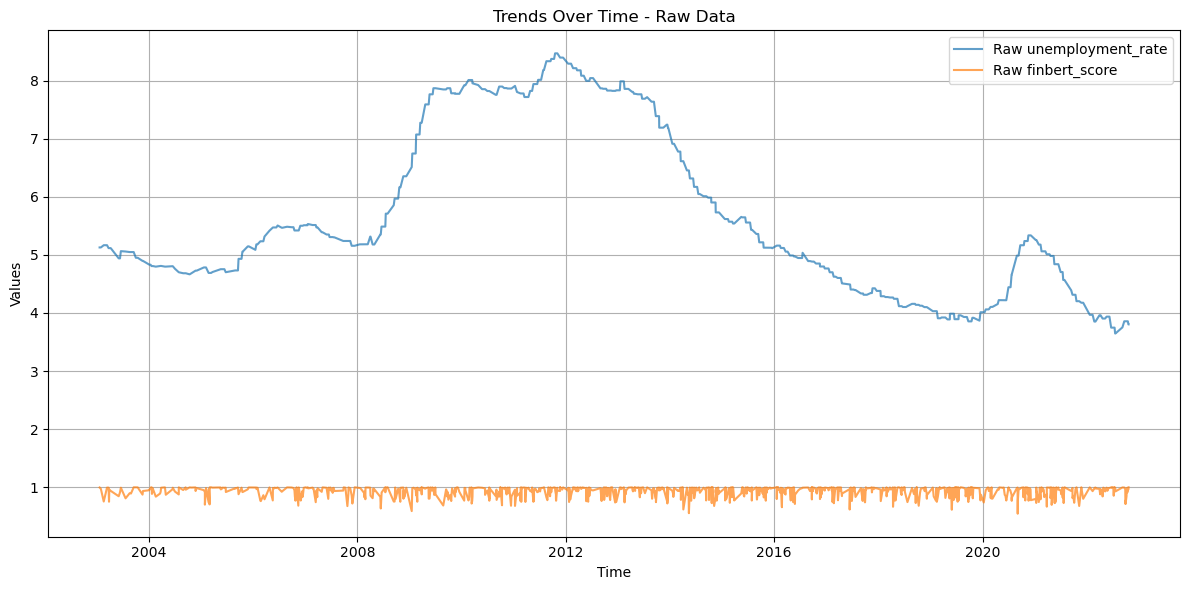

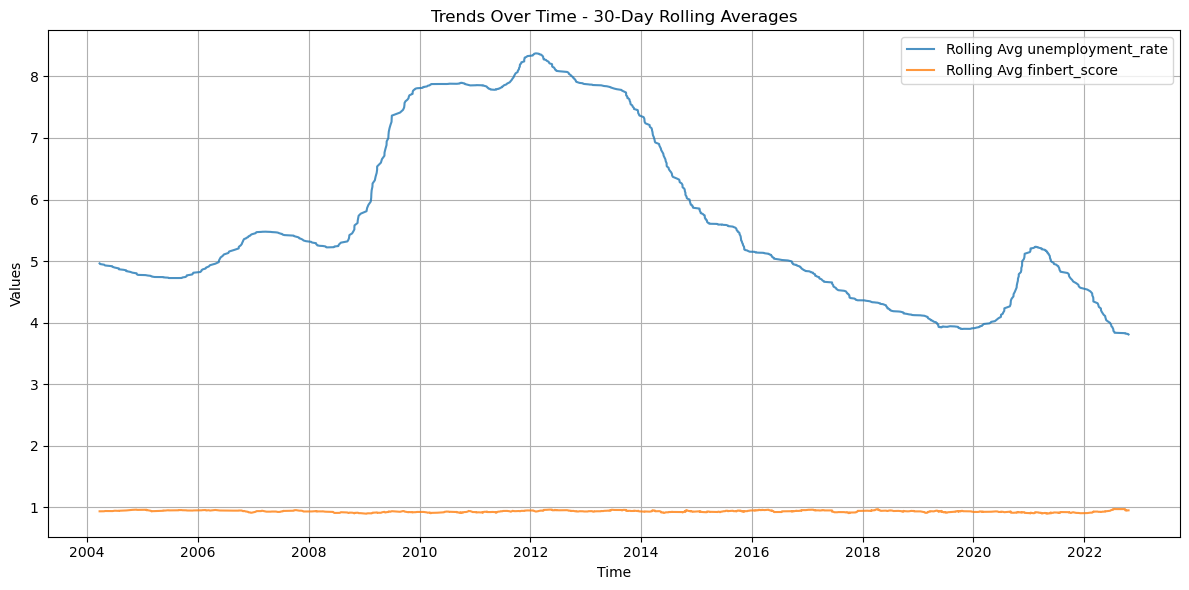

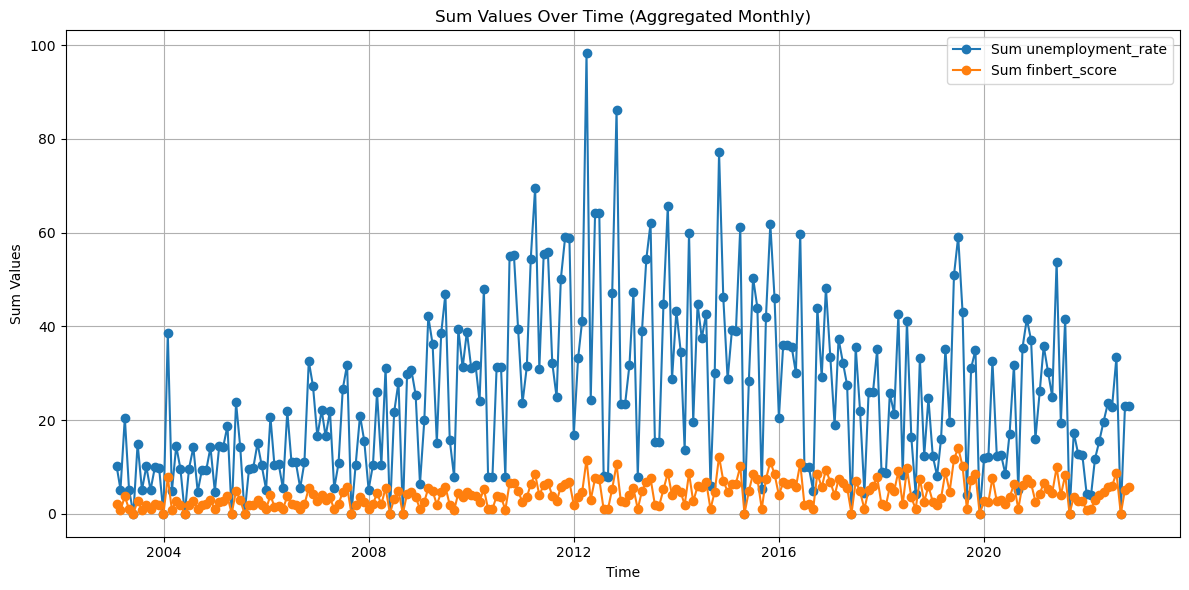

Visualization complete for economic_indicators


In [46]:
visualize_trend_over_time(merged_df, time_col='date', value_cols=['gdp_rate', 'finbert_score'], aggregation='sum', rolling_window=30, file_name="economic_indicators")
visualize_trend_over_time(merged_df, time_col='date', value_cols=['cpi_rate', 'finbert_score'], aggregation='sum', rolling_window=30, file_name="economic_indicators")
visualize_trend_over_time(merged_df, time_col='date', value_cols=['unemployment_rate', 'finbert_score'], aggregation='sum', rolling_window=30, file_name="economic_indicators")

##

<a id="Simple_Linear_Regression"></a>
## 3.1 Simple Linear Regression

### I. Correlation Matrix

In [58]:
# Select columns for correlation analysis
# This includes 'finbert_score' for sentiment and the economic indicators
correlation_columns = indicator_columns 

# Calculate the correlation matrix
correlation_matrix = merged_df[correlation_columns].corr()

print("Correlation Matrix")
print(correlation_matrix)


Correlation Matrix
                          finbert_score  gdp_rate  cpi_rate  \
finbert_score                  1.000000  0.002132 -0.002179   
gdp_rate                       0.002132  1.000000  0.090232   
cpi_rate                      -0.002179  0.090232  1.000000   
unemployment_rate             -0.004944 -0.040273 -0.065202   
weekly_earning_rate           -0.013869  0.056161 -0.159247   
redundancies                  -0.052683 -0.023587 -0.154973   
bank_rate                      0.001256 -0.065187  0.007280   
gilt_purchases_bn             -0.022612  0.143723  0.274378   
bond_purchases                -0.022276  0.097597  0.290733   
asset_purchase_decisions      -0.012466  0.176821  0.199649   

                          unemployment_rate  weekly_earning_rate  \
finbert_score                     -0.004944            -0.013869   
gdp_rate                          -0.040273             0.056161   
cpi_rate                          -0.065202            -0.159247   
unemployment_ra

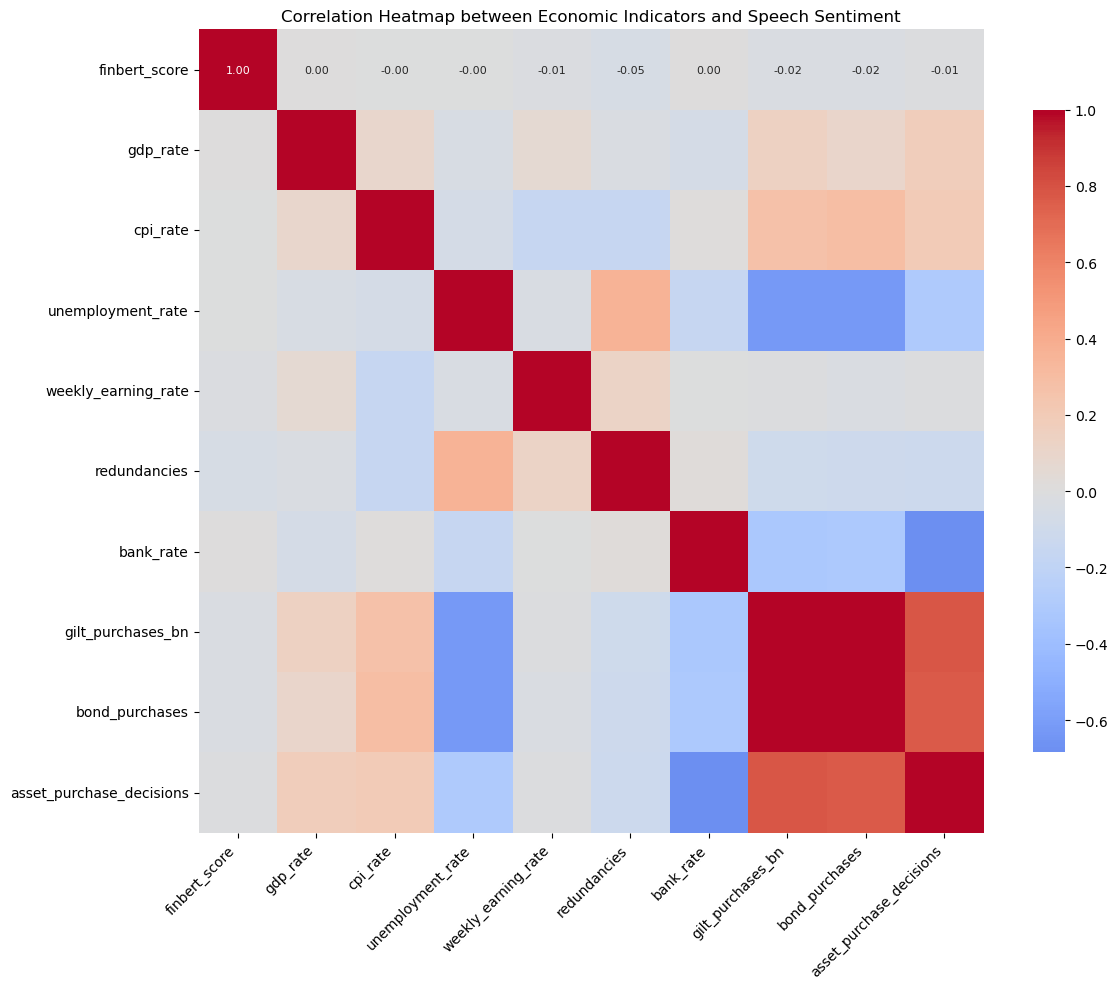

In [60]:
# Visualise the correlation matrix with a heatmap

# Set up the heatmap for the correlation matrix
plt.figure(figsize=(12, 10))
sns.heatmap(correlation_matrix, annot=True, cmap="coolwarm", center=0, fmt=".2f",
            cbar_kws={"shrink": .8}, annot_kws={"size": 8})

plt.title("Correlation Heatmap between Economic Indicators and Speech Sentiment")
plt.xticks(rotation=45, ha='right') 
plt.yticks(rotation=0)
plt.tight_layout() 
plt.show()


This correlation matrix reveals several insights into the relationships between economic indicators and sentiment scores related to Bank of England speeches: \
**The only variables with very weak but positive correlations with finbert_score** are:
- bank_rate (correlation: 0.001256)
- gdp_rate (correlation: 0.002132)
  
The strength of these correlations is minimal, so their explanatory power might be limited.

Include variables if they are supported by theory, even if the correlations are weak or negative.
- cpi_rate (important for understanding inflation sentiment dynamics)
- unemployment_rate (labor market relevance to financial sentiment)3
- bond_purchases or gilt_purchases_bn (quantitative easing effects)
- asset_purchase_decisions (broader monetary policy implications)

### 

### II. Simple Linear Regression for each of the variable 

In [72]:
# Simple Linear Regression Model:

# Function for performing linear regression analysis.
def perform_linear_regression(x, y, x_label, y_label, plot_title, scatter_color, line_color, feature_for_normality_test):
    """
    Perform linear regression on given x and y values, output metrics, plot results,
    create a Q-Q plot, and perform the Shapiro-Wilk test.
    """
    # Ensure x and y are in the correct format (2D for x)
    x = np.array(x).reshape(-1, 1)
    y = np.array(y)

    # Initialise the Linear Regression model
    lm = LinearRegression()

    # Fit the model
    lm.fit(x, y)

    # Calculate R-squared, intercept, and coefficient
    r_squared = lm.score(x, y)
    intercept = lm.intercept_
    coefficient = lm.coef_

    print(f"R-squared value: {r_squared}")
    print(f"Intercept value: {intercept}")
    print(f"Coefficient value: {coefficient}")

    # Use statsmodels for OLS regression and summary
    data = pd.DataFrame({'x': x.flatten(), 'y': y})
    ols_model = smf.ols(formula='y ~ x', data=data).fit()
    print(ols_model.summary())

    # Predict values
    y_pred = lm.predict(x)

    # Plot the actual vs predicted with the regression line
    plt.scatter(x, y, color=scatter_color, label='Actual data')
    plt.plot(x, y_pred, color=line_color, label='Regression line')
    plt.title(plot_title)
    plt.xlabel(x_label)
    plt.ylabel(y_label)
    plt.legend()
    plt.show()

    # Q-Q plot for normality check of the residuals
    sm.qqplot(feature_for_normality_test, fit=True, line='45')
    plt.ylabel("Quantiles of Feature")
    plt.xlabel("Normal Quantiles")
    plt.title("Q-Q plot")
    plt.show()

    # Shapiro-Wilk test for normality
    stat, p_value = shapiro(feature_for_normality_test)
    print(f"Shapiro-Wilk Test Statistic: {stat}, p-value: {p_value}")

    # Return model metrics as a dictionary
    return {'r_squared': r_squared, 'intercept': intercept, 'coefficient': coefficient, 'shapiro_stat': stat, 'shapiro_p': p_value}


R-squared value: 1.5781365444444972e-06
Intercept value: 0.928845117632399
Coefficient value: [0.00670998]
                            OLS Regression Results                            
Dep. Variable:                      y   R-squared:                       0.000
Model:                            OLS   Adj. R-squared:                 -0.001
Method:                 Least Squares   F-statistic:                  0.001667
Date:                Fri, 15 Nov 2024   Prob (F-statistic):              0.967
Time:                        18:15:49   Log-Likelihood:                 1087.0
No. Observations:                1058   AIC:                            -2170.
Df Residuals:                    1056   BIC:                            -2160.
Df Model:                           1                                         
Covariance Type:            nonrobust                                         
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------

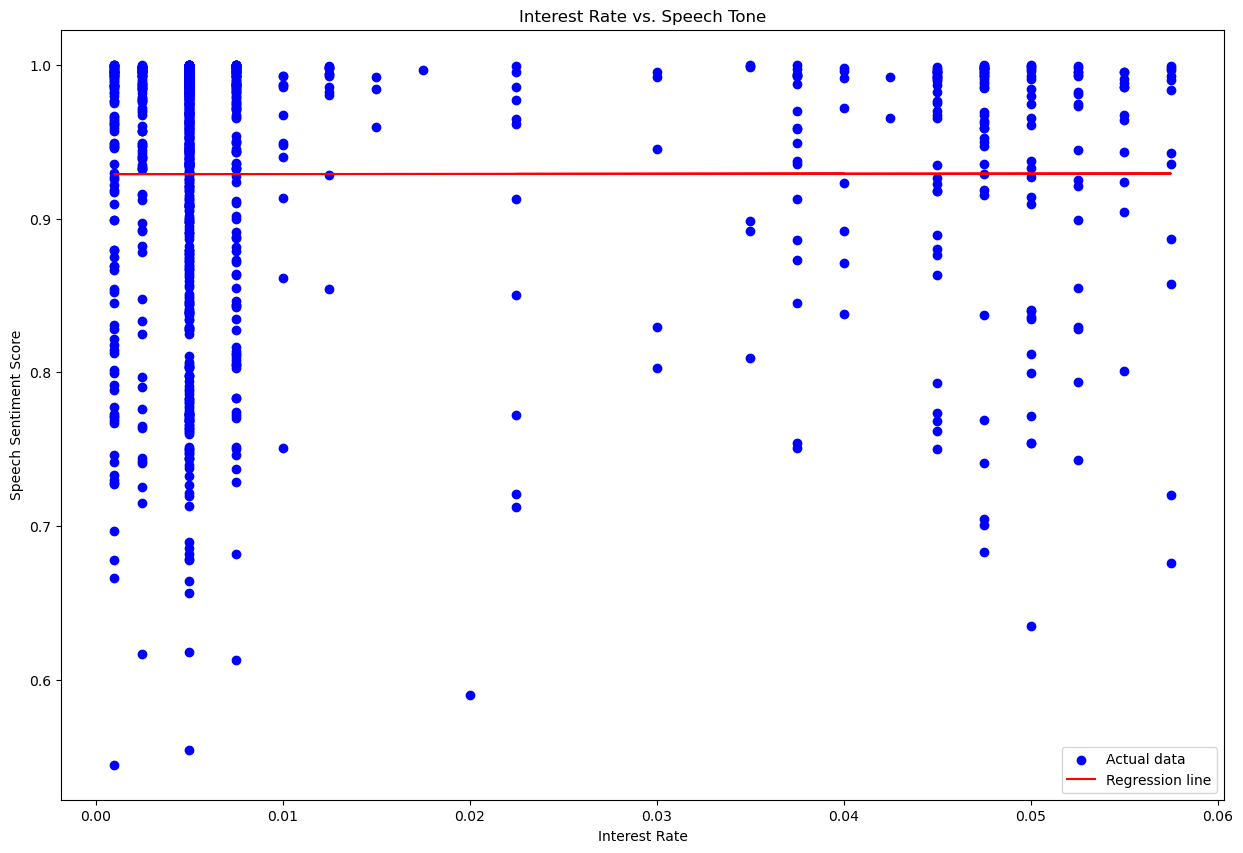

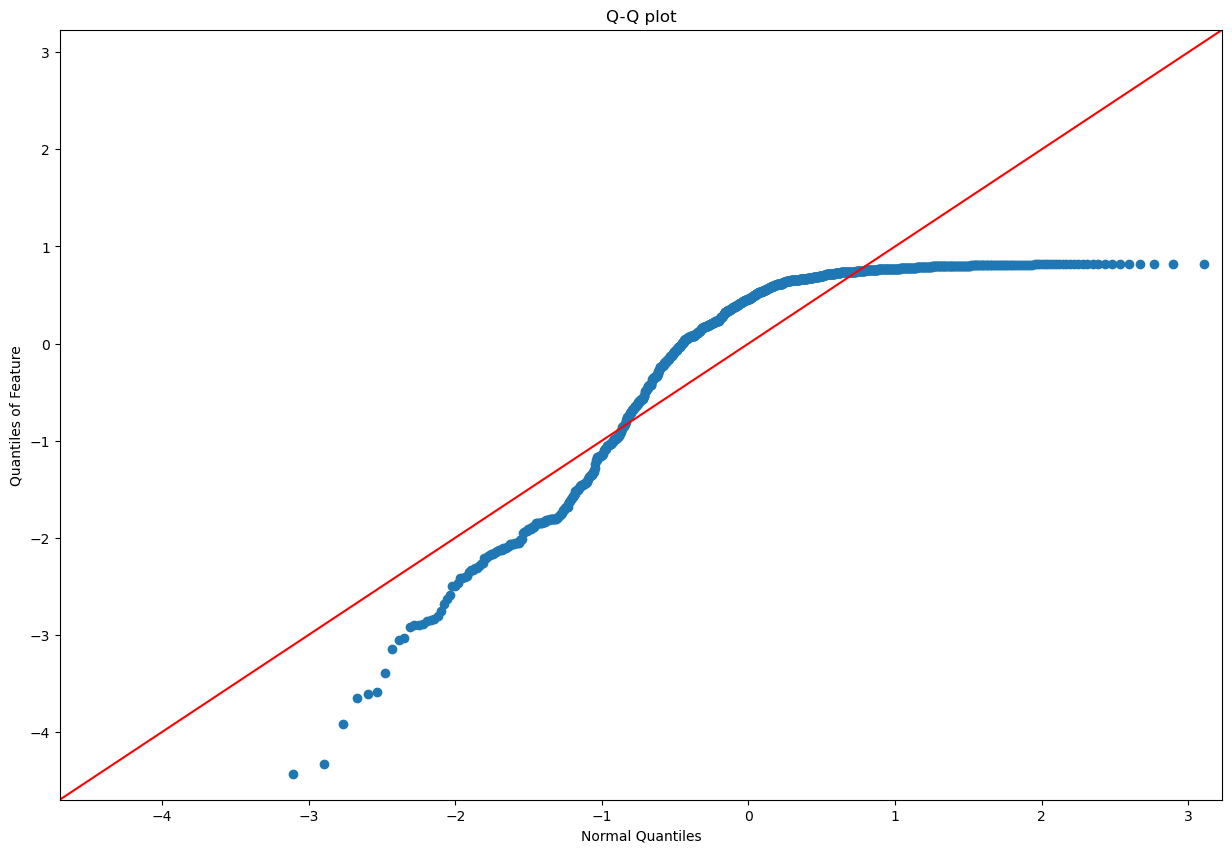

Shapiro-Wilk Test Statistic: 0.7855276465415955, p-value: 4.114907227676246e-35
{'r_squared': 1.5781365444444972e-06, 'intercept': 0.928845117632399, 'coefficient': array([0.00670998]), 'shapiro_stat': 0.7855276465415955, 'shapiro_p': 4.114907227676246e-35}


In [74]:
# I. Analysing the relationship between bank_rate and speech tone
metrics = perform_linear_regression(
    x=merged_df['bank_rate'],  # GDP as the predictor
    y=merged_df['finbert_score'],         # Speech tone as the target
    x_label='Interest Rate',
    y_label='Speech Sentiment Score',
    plot_title='Interest Rate vs. Speech Tone',
    scatter_color='blue',
    line_color='red',
    feature_for_normality_test=merged_df['finbert_score']
)

print(metrics)

R-squared value: 4.544548836804552e-06
Intercept value: 0.9288990708171069
Coefficient value: [0.0139921]
                            OLS Regression Results                            
Dep. Variable:                      y   R-squared:                       0.000
Model:                            OLS   Adj. R-squared:                 -0.001
Method:                 Least Squares   F-statistic:                  0.004799
Date:                Fri, 15 Nov 2024   Prob (F-statistic):              0.945
Time:                        14:38:24   Log-Likelihood:                 1087.0
No. Observations:                1058   AIC:                            -2170.
Df Residuals:                    1056   BIC:                            -2160.
Df Model:                           1                                         
Covariance Type:            nonrobust                                         
                 coef    std err          t      P>|t|      [0.025      0.975]
-------------------------

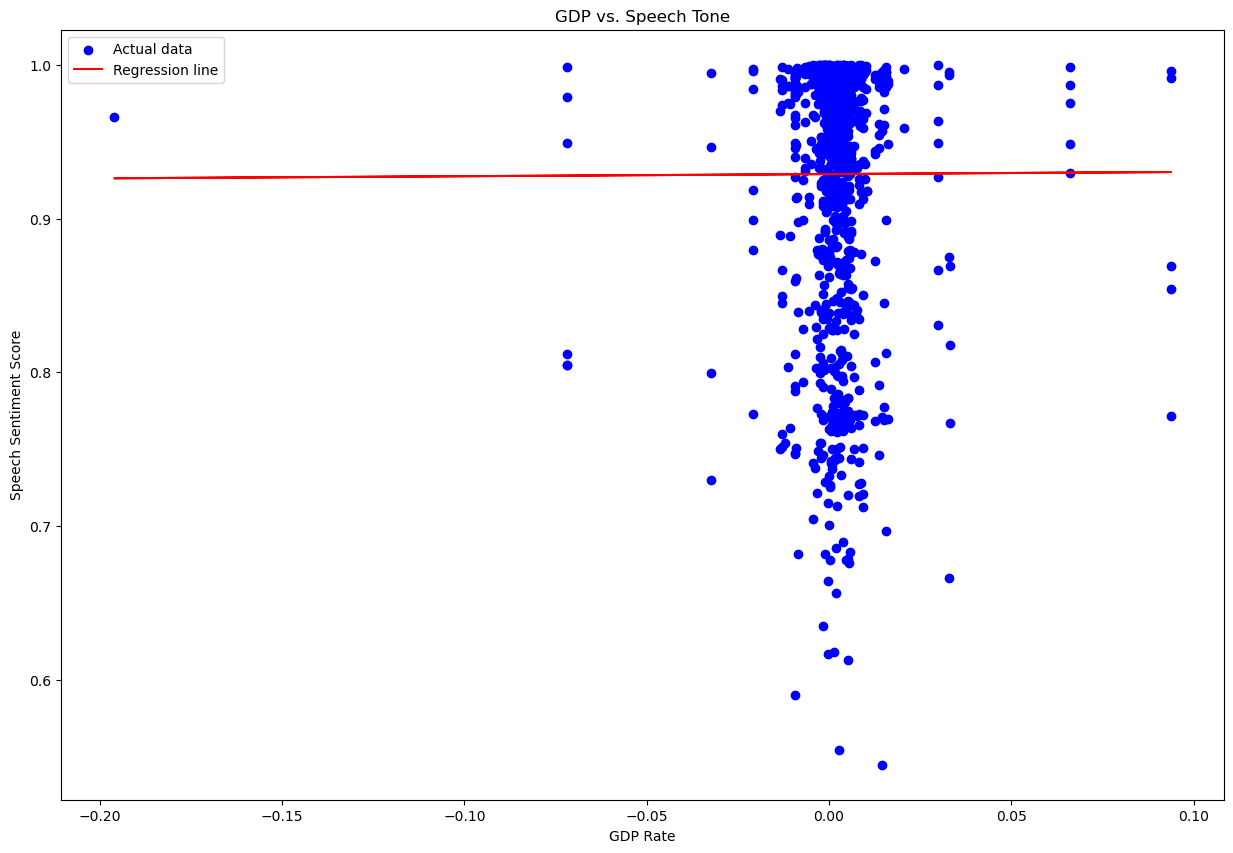

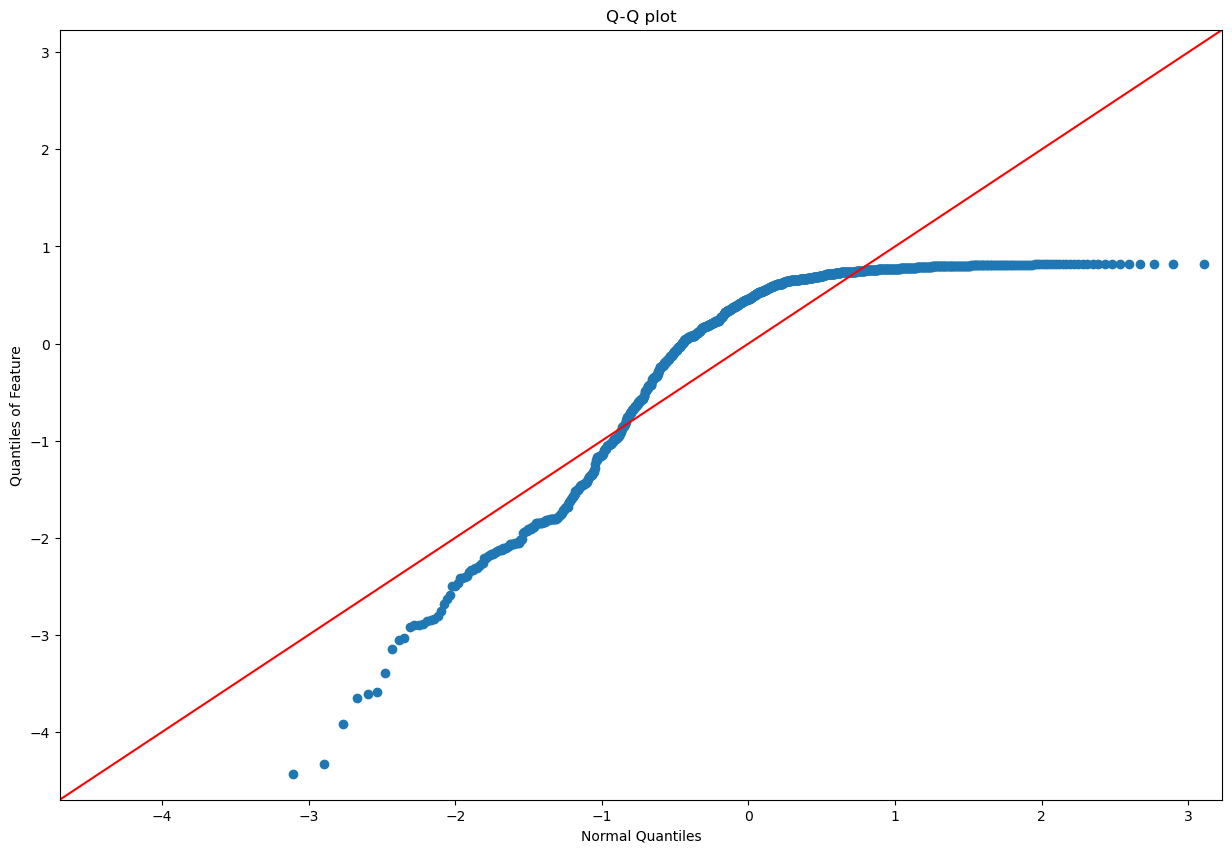

Shapiro-Wilk Test Statistic: 0.7855276465415955, p-value: 4.114907227676246e-35
{'r_squared': 4.544548836804552e-06, 'intercept': 0.9288990708171069, 'coefficient': array([0.0139921]), 'shapiro_stat': 0.7855276465415955, 'shapiro_p': 4.114907227676246e-35}


In [66]:
# II. Analysing the relationship between GDP growth and speech tone
metrics = perform_linear_regression(
    x=merged_df['gdp_rate'],  # GDP as the predictor
    y=merged_df['finbert_score'],         # Speech tone as the target
    x_label='GDP Rate',
    y_label='Speech Sentiment Score',
    plot_title='GDP vs. Speech Tone',
    scatter_color='blue',
    line_color='red',
    feature_for_normality_test=merged_df['finbert_score']
)

print(metrics)

**Simple linear Regression's Results:**


The simple linear regression results further confirm this weak relationship, with near-zero R-squared values (0.000 and 0.0000016). This indicates that the model’s explanatory power is virtually nonexistent, meaning **bank_rate** and **gdp_rate** have almost no predictive power for sentiment scores. Additionally, the regression’s high p-values for coefficients (0.967 and 0.945) suggest the relationships are statistically insignificant, underscoring that these indicators do not significantly influence the sentiment conveyed in the speeches.

##

<a id="Multiple_Linear_Regression"></a>
## 3.2 Multiple Linear Regression 

### I. Variance-inflation Factor (VIF)

In [76]:
# Function for checking the Variance inflation factor.
def calculate_vif(df, x_cols):
    X = df[x_cols]
    X = sm.add_constant(X)
    vif_data = pd.DataFrame()
    vif_data["Feature"] = X.columns
    vif_data["VIF"] = [variance_inflation_factor(X.values, i) for i in range(X.shape[1])]
    return vif_data

In [78]:
# x_columns multicollinearity
x_columns = ['gdp_rate', 'bank_rate']

# Calculate VIF
print(f"Checking for Variance Inflation Factors for multicollinearity")
print(calculate_vif(merged_df, x_columns))

Checking for Variance Inflation Factors for multicollinearity
     Feature       VIF
0      const  1.618266
1   gdp_rate  1.004267
2  bank_rate  1.004267


###

### II. Multiple Linear Regression

In [82]:
# Multiple Linear Regression:

# Function for performing multiple linear regression analysis.
def multiple_regression(df, y_col, x_cols):
    # Prepare the data
    X = df[x_cols]  # Multiple independent variables
    y = df[y_col]   # Dependent variable
    X = sm.add_constant(X)  # Adds the intercept term

    # Fit the OLS model
    model = sm.OLS(y, X).fit()

    # Print the model summary
    print(model.summary())

    # Plot the results
    visualise_results(df, y_col, x_cols, model)

    return model

def visualise_results(df, y_col, x_cols, model):
    # Residuals plot (Predicted vs Actual)
    plt.figure(figsize=(10, 6))
    predictions = model.predict(sm.add_constant(df[x_cols]))
    plt.scatter(predictions, model.resid, alpha=0.5)
    plt.axhline(0, color='red', linestyle='--')
    plt.title('Residuals Plot (Predicted vs Residuals)')
    plt.xlabel('Predicted Values')
    plt.ylabel('Residuals')
    plt.show()

    # Distribution of residuals
    plt.figure(figsize=(10, 6))
    sns.histplot(model.resid, kde=True)
    plt.title('Distribution of Residuals')
    plt.xlabel('Residuals')
    plt.ylabel('Density')
    plt.show()


                            OLS Regression Results                            
Dep. Variable:          finbert_score   R-squared:                       0.000
Model:                            OLS   Adj. R-squared:                 -0.002
Method:                 Least Squares   F-statistic:                  0.003428
Date:                Fri, 15 Nov 2024   Prob (F-statistic):              0.997
Time:                        18:16:03   Log-Likelihood:                 1087.0
No. Observations:                1058   AIC:                            -2168.
Df Residuals:                    1055   BIC:                            -2153.
Df Model:                           2                                         
Covariance Type:            nonrobust                                         
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
const          0.9288      0.003    273.822      0.0

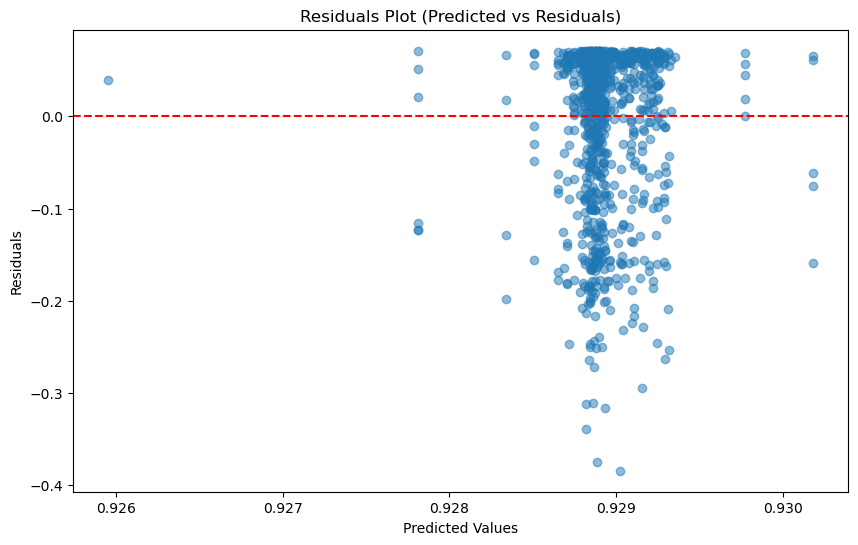

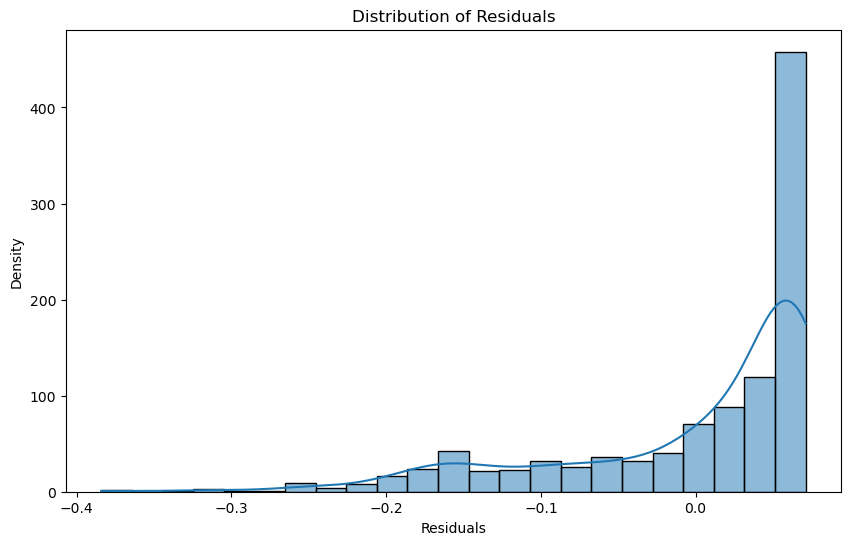

In [84]:
# Apply the function for the indipendent variables: 'bank_rate', 
x_columns = ['gdp_rate', 'bank_rate']

# Independent variables
multiple_regression(merged_df, y_col='finbert_score', x_cols=x_columns)

**Multiple Linear Regression's Results:**

The multiple regression analysis yields an R-squared of 0.000, showing the model fails to explain any variation in FinBERT sentiment scores using **gdp_rate** and **bank_rate**. High p-values (0.943 and 0.964) indicate the model cannot establish significant relationships between these indicators and sentiment. The near-zero F-statistic (0.003) confirms the model's inability to capture meaningful patterns, suggesting its limitations in linking economic indicators to sentiment effectively.

**[Table of Contents](#Table_of_contents)**

#

<a id="Vector_Autoregression_(VAR)_Model"></a>
# 4. Correlation Analysis: Vector Autoregression (VAR) Model

<a id="Data_Cleaning"></a>
## 4.1	Vector Autoregression (VAR) Model

### I. Data Preparation

In [62]:
# Drop unecessary columns
merged_df = merged_df.drop(['text_length', 'unemployment_rate_change'], axis=1)

In [64]:
# List of indicator columns to use
indicator_columns = ['gdp_rate', 'cpi_rate', 'bank_rate', 'weekly_earning_rate']

# Fill NaNs in indicator columns with a moving average (3-month window)
for column in indicator_columns:
    merged_df[column].fillna(merged_df[column].rolling(window=3, min_periods=1).mean(), inplace=True)

# Apply quarterly lags (3-month interval)
for column in indicator_columns:
    for lag in [3, 6, 9]:  # Quarterly lags
        merged_df[f'{column}_lag_{lag}'] = merged_df[column].shift(lag)

# Check the resulting column names
print(f"\nResulting DF's columns:")
print(merged_df.columns)

merged_df.head()


Resulting DF's columns:
Index(['reference', 'date', 'author', 'year', 'finbert_sentiment',
       'finbert_score', 'gdp_rate', 'cpi_rate', 'unemployment_rate',
       'weekly_earning_rate', 'redundancies', 'bank_rate', 'gilt_purchases_bn',
       'bond_purchases', 'asset_purchase_decisions', 'gdp_rate_lag_3',
       'gdp_rate_lag_6', 'gdp_rate_lag_9', 'cpi_rate_lag_3', 'cpi_rate_lag_6',
       'cpi_rate_lag_9', 'bank_rate_lag_3', 'bank_rate_lag_6',
       'bank_rate_lag_9', 'weekly_earning_rate_lag_3',
       'weekly_earning_rate_lag_6', 'weekly_earning_rate_lag_9'],
      dtype='object')


,reference,date,author,year,finbert_sentiment,finbert_score,gdp_rate,cpi_rate,unemployment_rate,weekly_earning_rate,...,gdp_rate_lag_9,cpi_rate_lag_3,cpi_rate_lag_6,cpi_rate_lag_9,bank_rate_lag_3,bank_rate_lag_6,bank_rate_lag_9,weekly_earning_rate_lag_3,weekly_earning_rate_lag_6,weekly_earning_rate_lag_9
0,r030120a_BOE,2003-01-20,george,2003,Neutral,0.996209,0.004033,0.003587,5.127928,0.004170,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1,r030129a_BOE,2003-01-29,bean,2003,Neutral,0.971784,0.004033,0.003587,5.127928,0.004170,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2,r030218a_BOE,2003-02-18,barker,2003,Negative,0.754248,-0.002150,0.003547,5.166501,0.013887,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
3,r030313a_BOE,2003-03-13,large,2003,Neutral,0.994006,-0.002150,0.003547,5.166501,0.013887,...,NaN,0.003587,NaN,NaN,0.04,NaN,NaN,0.00417,NaN,NaN
4,r030324a_BOE,2003-03-24,george,2003,Neutral,0.993341,0.009420,0.003282,5.116309,-0.002546,...,NaN,0.003587,NaN,NaN,0.04,NaN,NaN,0.00417,NaN,NaN


In [66]:
# Calculate a 3-month moving average for each indicator
for column in indicator_columns:
    merged_df[f'{column}_3_month_avg'] = merged_df[column].rolling(window=3, min_periods=1).mean()

print(merged_df.columns)
merged_df.head()


Index(['reference', 'date', 'author', 'year', 'finbert_sentiment',
       'finbert_score', 'gdp_rate', 'cpi_rate', 'unemployment_rate',
       'weekly_earning_rate', 'redundancies', 'bank_rate', 'gilt_purchases_bn',
       'bond_purchases', 'asset_purchase_decisions', 'gdp_rate_lag_3',
       'gdp_rate_lag_6', 'gdp_rate_lag_9', 'cpi_rate_lag_3', 'cpi_rate_lag_6',
       'cpi_rate_lag_9', 'bank_rate_lag_3', 'bank_rate_lag_6',
       'bank_rate_lag_9', 'weekly_earning_rate_lag_3',
       'weekly_earning_rate_lag_6', 'weekly_earning_rate_lag_9',
       'gdp_rate_3_month_avg', 'cpi_rate_3_month_avg', 'bank_rate_3_month_avg',
       'weekly_earning_rate_3_month_avg'],
      dtype='object')


,reference,date,author,year,finbert_sentiment,finbert_score,gdp_rate,cpi_rate,unemployment_rate,weekly_earning_rate,...,bank_rate_lag_3,bank_rate_lag_6,bank_rate_lag_9,weekly_earning_rate_lag_3,weekly_earning_rate_lag_6,weekly_earning_rate_lag_9,gdp_rate_3_month_avg,cpi_rate_3_month_avg,bank_rate_3_month_avg,weekly_earning_rate_3_month_avg
0,r030120a_BOE,2003-01-20,george,2003,Neutral,0.996209,0.004033,0.003587,5.127928,0.004170,...,NaN,NaN,NaN,NaN,NaN,NaN,0.004033,0.003587,0.040000,0.004170
1,r030129a_BOE,2003-01-29,bean,2003,Neutral,0.971784,0.004033,0.003587,5.127928,0.004170,...,NaN,NaN,NaN,NaN,NaN,NaN,0.004033,0.003587,0.040000,0.004170
2,r030218a_BOE,2003-02-18,barker,2003,Negative,0.754248,-0.002150,0.003547,5.166501,0.013887,...,NaN,NaN,NaN,NaN,NaN,NaN,0.001972,0.003574,0.039167,0.007409
3,r030313a_BOE,2003-03-13,large,2003,Neutral,0.994006,-0.002150,0.003547,5.166501,0.013887,...,0.04,NaN,NaN,0.00417,NaN,NaN,-0.000089,0.003560,0.038333,0.010648
4,r030324a_BOE,2003-03-24,george,2003,Neutral,0.993341,0.009420,0.003282,5.116309,-0.002546,...,0.04,NaN,NaN,0.00417,NaN,NaN,0.001706,0.003459,0.037500,0.008409


In [68]:
# Check for missing and infinite values
missing_values = merged_df.isnull().sum()
print("Missing Values:\n", missing_values)

infinite_values = merged_df.isin([np.inf, -np.inf]).sum()
print("\nInfinite Values:\n", infinite_values)

# Clean the DataFrame
merged_df.replace([np.inf, -np.inf], np.nan, inplace=True)  # Replace inf with NaN
merged_df.dropna(inplace=True)  # Drop rows with NaN in x_columns


Missing Values:
 reference                          0
date                               0
author                             0
year                               0
finbert_sentiment                  0
finbert_score                      0
gdp_rate                           0
cpi_rate                           0
unemployment_rate                  0
weekly_earning_rate                0
redundancies                       0
bank_rate                          0
gilt_purchases_bn                  0
bond_purchases                     0
asset_purchase_decisions           0
gdp_rate_lag_3                     3
gdp_rate_lag_6                     6
gdp_rate_lag_9                     9
cpi_rate_lag_3                     3
cpi_rate_lag_6                     6
cpi_rate_lag_9                     9
bank_rate_lag_3                    3
bank_rate_lag_6                    6
bank_rate_lag_9                    9
weekly_earning_rate_lag_3          3
weekly_earning_rate_lag_6          6
weekly_earning_rate_l

In [70]:
# Save the resulting DataFrame as a .csv file
merged_df.to_csv('lagged_df.csv', index=False)

In [72]:
# Select columns for correlation analysis
# This includes 'finbert_score' for sentiment, the economic indicators, and their lagged versions
correlation_columns = (
    indicator_columns
    + [f'{col}_lag_{lag}' for col in indicator_columns for lag in [3, 6, 9]]
    + [f'{column}_3_month_avg' for column in indicator_columns]
    + ['unemployment_rate', 'weekly_earning_rate', 'redundancies']
)

                                                                                                                    
# Calculate the correlation matrix
correlation_matrix = merged_df[correlation_columns].corr()

# Display the correlation matrix
print("Correlation Matrix")
print(correlation_matrix)


Correlation Matrix
                                 gdp_rate  cpi_rate  bank_rate  \
gdp_rate                         1.000000  0.090274  -0.069275   
cpi_rate                         0.090274  1.000000   0.005692   
bank_rate                       -0.069275  0.005692   1.000000   
weekly_earning_rate              0.057719 -0.160299  -0.005271   
gdp_rate_lag_3                   0.454439  0.054957  -0.056496   
gdp_rate_lag_6                   0.095727  0.053479  -0.045125   
gdp_rate_lag_9                  -0.127234  0.005291  -0.040224   
cpi_rate_lag_3                   0.025972  0.525581   0.010683   
cpi_rate_lag_6                  -0.011319  0.356279   0.018541   
cpi_rate_lag_9                  -0.017347  0.249884   0.021386   
bank_rate_lag_3                 -0.078001 -0.009844   0.995788   
bank_rate_lag_6                 -0.076199 -0.025209   0.989375   
bank_rate_lag_9                 -0.073282 -0.033333   0.980066   
weekly_earning_rate_lag_3        0.060302 -0.009417  -0.0

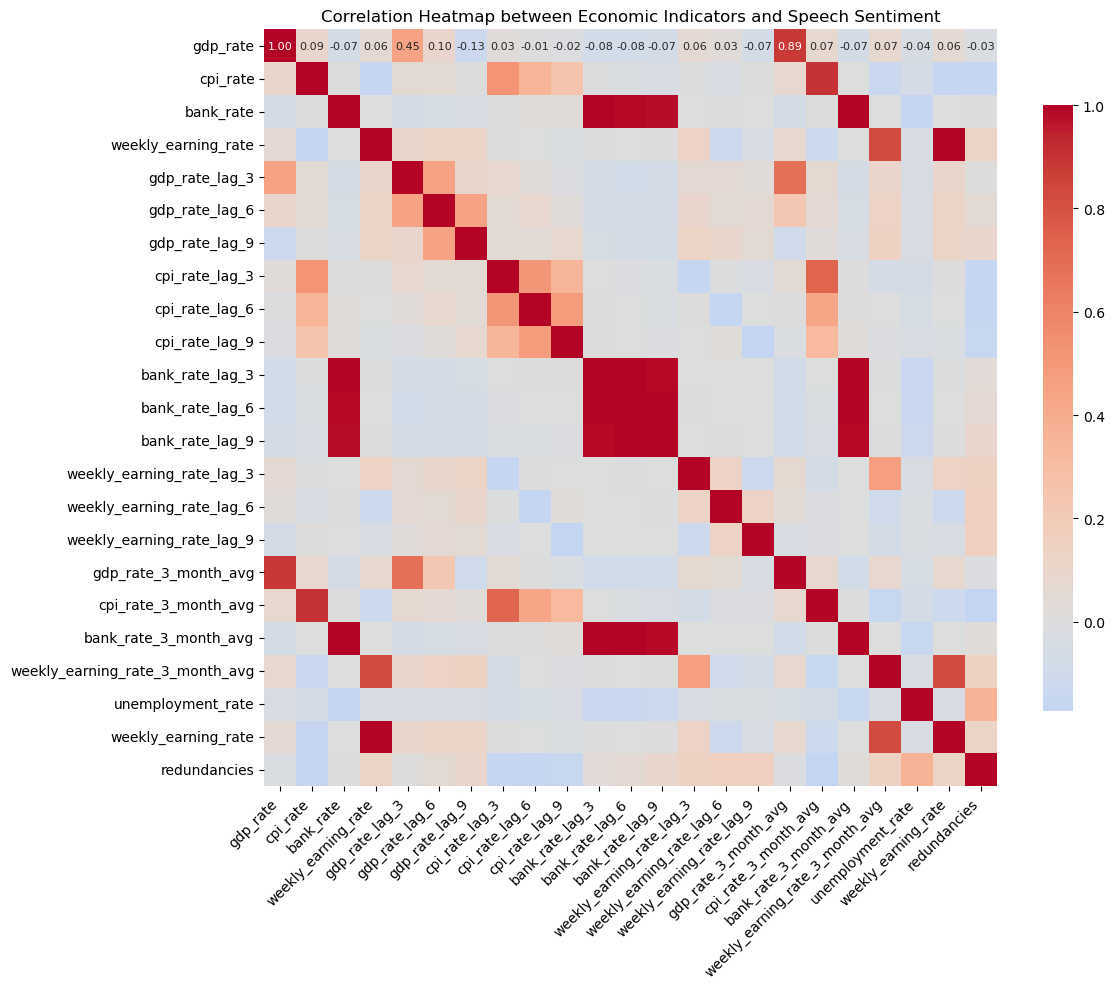

In [74]:
# Visualise the correlation matrix with a heatmap

# Set up the heatmap for the correlation matrix
plt.figure(figsize=(12, 10))
sns.heatmap(correlation_matrix, annot=True, cmap="coolwarm", center=0, fmt=".2f",
            cbar_kws={"shrink": .8}, annot_kws={"size": 8})

# Customise the heatmap for better readability
plt.title("Correlation Heatmap between Economic Indicators and Speech Sentiment")
plt.xticks(rotation=45, ha='right')
plt.yticks(rotation=0)
plt.tight_layout()  
plt.show()


**1. Variables with strong/moderate correlations and likely relevant to finbert_score:**
- **gdp_rate:** Strong positive correlation with its own lagged values and moderately correlated with other economic indicators. Relevant for capturing macroeconomic trends that could influence finbert_score.
- **cpi_rate and cpi_rate_lag_3:** Inflation is a key driver in economic sentiment, making these relevant.
- **bank_rate:** This monetary policy variable has moderate correlations with lagged versions of itself and influences economic conditions, likely impacting finbert_score.
- **unemployment_rate:** While weakly correlated with most variables, its direct relationship with labor market outcomes and sentiment-based variables justifies its inclusion.
- **redundancies:** Correlated with unemployment_rate and reflects labor market shocks, potentially tied to sentiment changes.
- **gdp_rate_lag_3 and cpi_rate_lag_3:** Lagged macroeconomic indicators are often useful, especially when explaining temporal relationships.
- **weekly_earning_rate:** Although it has weak correlations overall, its connection to labor market trends and redundancies might be relevant.
___

**2. Variables with weak/irrelevant correlations and less relevant for finbert_score:**
- **Variables with consistently weak correlations:** bank_rate_lag_9, bank_rate_3_month_avg, cpi_rate_lag_6 and cpi_rate_lag_9.
- **Highly autocorrelated variables with little cross-variable interaction:** gdp_rate_3_month_avg and bank_rate_lag_3.


In [80]:
# Selecting relevant columns for correlation
correlation_cols = ['finbert_score', 'gdp_rate',  'gdp_rate_lag_3', 'cpi_rate', 'cpi_rate_lag_3',
                    'bank_rate', 'unemployment_rate', 'redundancies', 'weekly_earning_rate']

correlation_matrix = merged_df[correlation_cols].corr()

# Display the correlation matrix
print("Correlation Matrix")
print(correlation_matrix)

Correlation Matrix
                     finbert_score  gdp_rate  gdp_rate_lag_3  cpi_rate  \
finbert_score             1.000000  0.002306       -0.037701 -0.003016   
gdp_rate                  0.002306  1.000000        0.454439  0.090274   
gdp_rate_lag_3           -0.037701  0.454439        1.000000  0.054957   
cpi_rate                 -0.003016  0.090274        0.054957  1.000000   
cpi_rate_lag_3           -0.025886  0.025972        0.088830  0.525581   
bank_rate                 0.003837 -0.069275       -0.056496  0.005692   
unemployment_rate        -0.005728 -0.039475       -0.039348 -0.065060   
redundancies             -0.052235 -0.025188        0.012418 -0.156788   
weekly_earning_rate      -0.012693  0.057719        0.099436 -0.160299   

                     cpi_rate_lag_3  bank_rate  unemployment_rate  \
finbert_score             -0.025886   0.003837          -0.005728   
gdp_rate                   0.025972  -0.069275          -0.039475   
gdp_rate_lag_3             0.0888

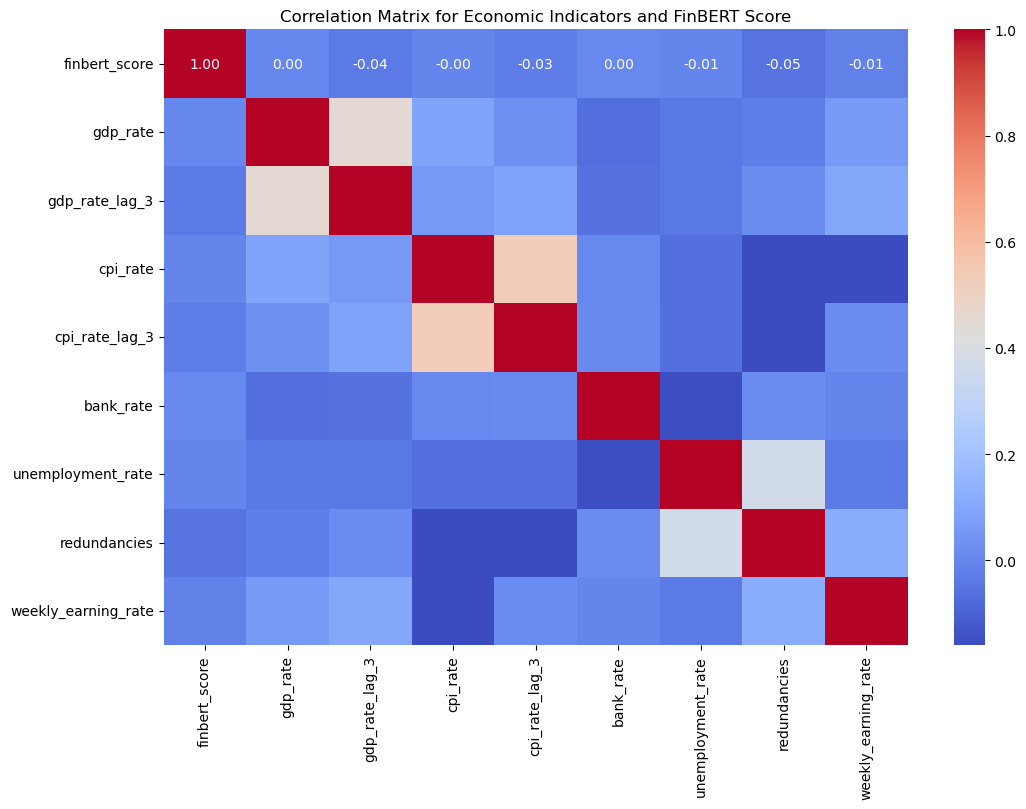

In [82]:
correlation_matrix = merged_df[correlation_cols].corr()
plt.figure(figsize=(12, 8))
sns.heatmap(correlation_matrix, annot=True, cmap='coolwarm', fmt='.2f')
plt.title("Correlation Matrix for Economic Indicators and FinBERT Score")
plt.show()

In [84]:
# Function for checking the Variance inflation factor.
def calculate_vif(df, x_cols):
    X = df[x_cols]
    X = sm.add_constant(X)
    vif_data = pd.DataFrame()
    vif_data["Feature"] = X.columns
    vif_data["VIF"] = [variance_inflation_factor(X.values, i) for i in range(X.shape[1])]
    return vif_data

# x_columns multicollinearity
x_columns = ['gdp_rate',  'gdp_rate_lag_3', 'cpi_rate', 'cpi_rate_lag_3', 'bank_rate', 'unemployment_rate', 'redundancies', 'weekly_earning_rate']


# Calculate VIF
print(f"Checking for Variance Inflation Factors for multicollinearity")
print(calculate_vif(merged_df, x_columns))

Checking for Variance Inflation Factors for multicollinearity
               Feature        VIF
0                const  20.390729
1             gdp_rate   1.278687
2       gdp_rate_lag_3   1.282685
3             cpi_rate   1.460089
4       cpi_rate_lag_3   1.429207
5            bank_rate   1.038318
6    unemployment_rate   1.204243
7         redundancies   1.219882
8  weekly_earning_rate   1.073369


### 

### II. Model Fit and Visualisations

In [88]:
# Check for unit roots using the Augmented Dickey-Fuller (ADF) test on each series and difference them if necessary to achieve stationarity.
# Create a copy to avoid modifying the original dataframe
var_data = merged_df[ ['finbert_score', 'gdp_rate',  'gdp_rate_lag_3', 'cpi_rate', 'cpi_rate_lag_3', 'bank_rate', 
                       'unemployment_rate', 'redundancies', 'weekly_earning_rate']].copy()

# Augmented Dickey-Fuller (ADF) test for stationarity: variables with low p-values(<0.05) are stationary.
def adf_test(series):
    result = adfuller(series.dropna())
    return {'ADF Statistic': result[0], 'p-value': result[1]}

# Run ADF test on key variables
for col in correlation_cols:
    print(f'{col}:', adf_test(var_data[col]))

finbert_score: {'ADF Statistic': -31.443311090555188, 'p-value': 0.0}
gdp_rate: {'ADF Statistic': -9.932687610333158, 'p-value': 2.795740449077757e-17}
gdp_rate_lag_3: {'ADF Statistic': -9.923479759525422, 'p-value': 2.948623472969941e-17}
cpi_rate: {'ADF Statistic': -7.774456170175008, 'p-value': 8.74442550007097e-12}
cpi_rate_lag_3: {'ADF Statistic': -6.8087071948734295, 'p-value': 2.1435678002066318e-09}
bank_rate: {'ADF Statistic': -2.0121057168206, 'p-value': 0.28129051916525794}
unemployment_rate: {'ADF Statistic': -1.1210557754712855, 'p-value': 0.7066024854394346}
redundancies: {'ADF Statistic': -4.3096468035281505, 'p-value': 0.00042743243482586953}
weekly_earning_rate: {'ADF Statistic': -11.109182075575726, 'p-value': 3.696874758797062e-20}


In [90]:
# First difference the non-stationary 'unemployment_rate' series and add it back to merged_df
var_data['unemployment_rate_diff'] = var_data['unemployment_rate'].diff()
var_data['bank_rate_diff'] = var_data['bank_rate'].diff()

# Add differenced series back to the original dataframe
merged_df['unemployment_rate_diff'] = var_data['unemployment_rate_diff']
merged_df['bank_rate_diff'] = var_data['bank_rate_diff']

In [92]:
merged_df.set_index('date', inplace=True)  # Set 'date' as the index

In [94]:
# Function to fit the VAR model
def fit_var_model(df, target_vars, maxlags=12):
    """
    Fits a VAR model and selects the optimal lag order.
    Converts the index to a DateTimeIndex if it's not already set.
    """
    # Prepare the data by selecting the target variables and dropping any rows with missing values
    model_data = df[target_vars].dropna()

    # Check if the index is already a DateTimeIndex; if not, attempt to convert it
    if not isinstance(model_data.index, pd.DatetimeIndex):
        try:
            model_data.index = pd.to_datetime(model_data.index)
            print("Index converted to DateTimeIndex.")
        except Exception as e:
            raise ValueError("The DataFrame index must be a DateTimeIndex or convertible to one for time-based forecasting.") from e

    # Fit the VAR model
    model = VAR(model_data)
    lag_order_selection = model.select_order(maxlags=maxlags)
    optimal_lag_order = lag_order_selection.selected_orders['aic']  # Get AIC optimal order
    
    print(f"Optimal lag order selected based on AIC: {optimal_lag_order}")

    model_fit = model.fit(optimal_lag_order)
    print(model_fit.summary())
    
    # Return the fitted model, optimal lag order, and the prepared data
    return model_fit, optimal_lag_order, model_data


In [96]:
# 1st attempt
# Define the target variables including the differenced series
target_vars = ['finbert_score', 'gdp_rate',  'gdp_rate_lag_3', 'cpi_rate', 'cpi_rate_lag_3', 'bank_rate_diff',
               'unemployment_rate_diff', 'redundancies', 'weekly_earning_rate']

# Fit the VAR model
result_1 = model_fit, optimal_lag_order, model_data = fit_var_model(merged_df, target_vars)

Optimal lag order selected based on AIC: 3
  Summary of Regression Results   
Model:                         VAR
Method:                        OLS
Date:           Mon, 18, Nov, 2024
Time:                     12:33:41
--------------------------------------------------------------------
No. of Equations:         9.00000    BIC:                   -168.167
Nobs:                     1045.00    HQIC:                  -168.908
Log likelihood:           75397.8    FPE:                2.80319e-74
AIC:                     -169.361    Det(Omega_mle):     2.20954e-74
--------------------------------------------------------------------
Results for equation finbert_score
                               coefficient       std. error           t-stat            prob
--------------------------------------------------------------------------------------------
const                             0.920362         0.051087           18.016           0.000
L1.finbert_score                  0.022961         0.0

In [98]:
# 2nd Attempt
# Define the target variables including the differenced series
target_vars_2 = ['finbert_score', 'gdp_rate',  'gdp_rate_lag_3', 'cpi_rate', 'cpi_rate_lag_3', 'redundancies', 'weekly_earning_rate']

# Fit the VAR model
model_fit, optimal_lag_order, model_data = fit_var_model(merged_df, target_vars_2)

Optimal lag order selected based on AIC: 3
  Summary of Regression Results   
Model:                         VAR
Method:                        OLS
Date:           Mon, 18, Nov, 2024
Time:                     12:33:42
--------------------------------------------------------------------
No. of Equations:         7.00000    BIC:                   -164.540
Nobs:                     1046.00    HQIC:                  -164.992
Log likelihood:           76200.1    FPE:                1.67770e-72
AIC:                     -165.269    Det(Omega_mle):     1.45024e-72
--------------------------------------------------------------------
Results for equation finbert_score
                            coefficient       std. error           t-stat            prob
-----------------------------------------------------------------------------------------
const                          0.921279         0.050917           18.094           0.000
L1.finbert_score               0.023471         0.031224       

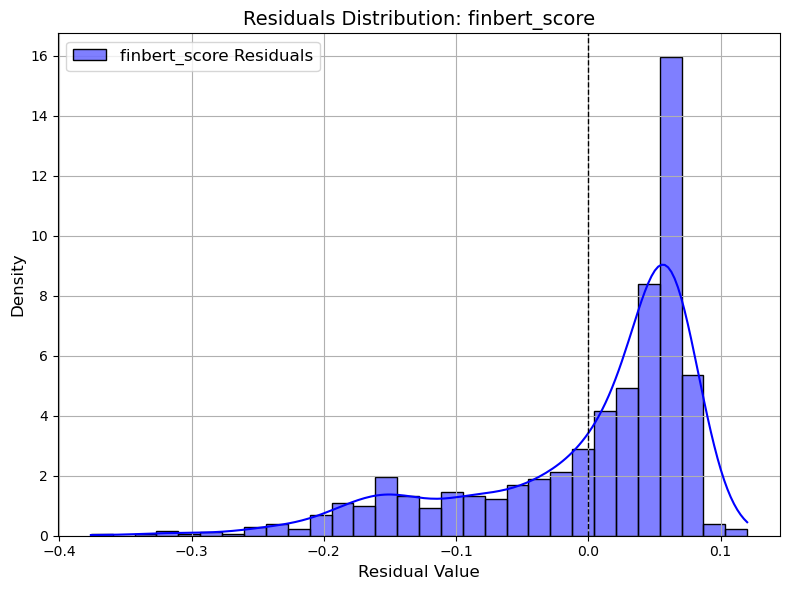

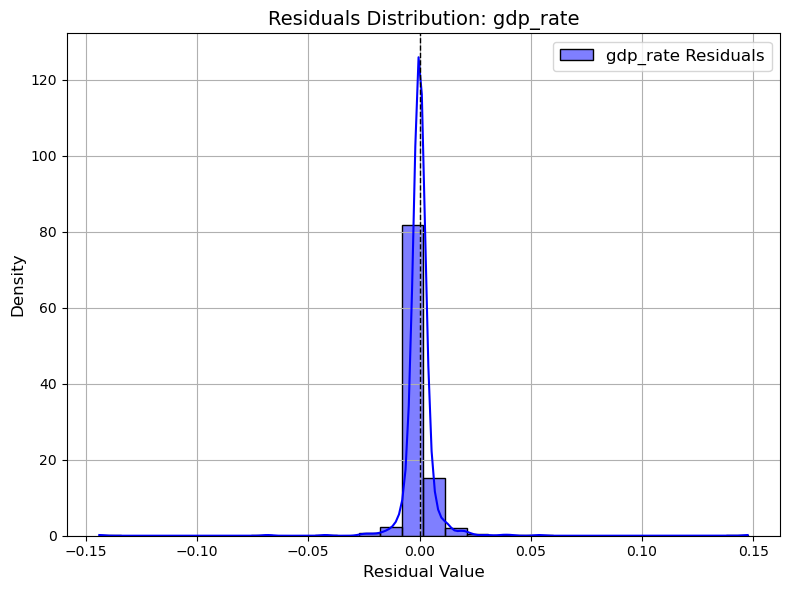

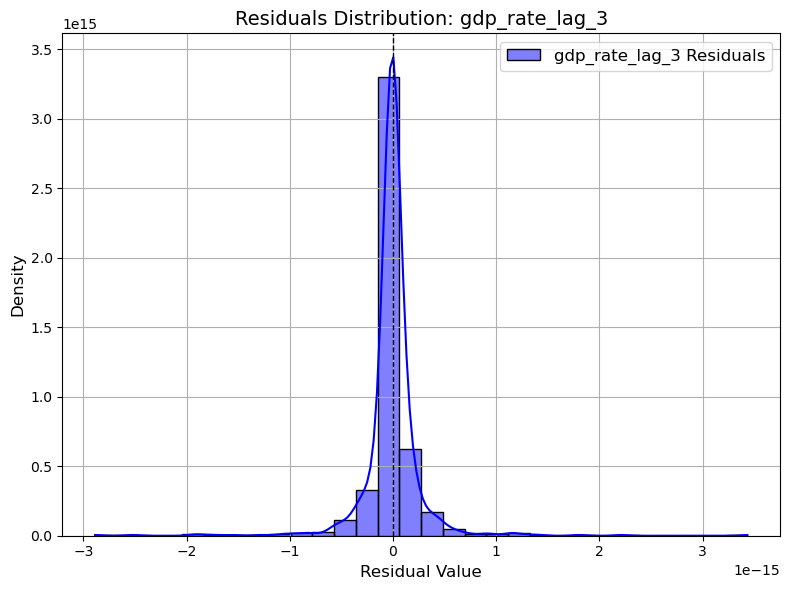

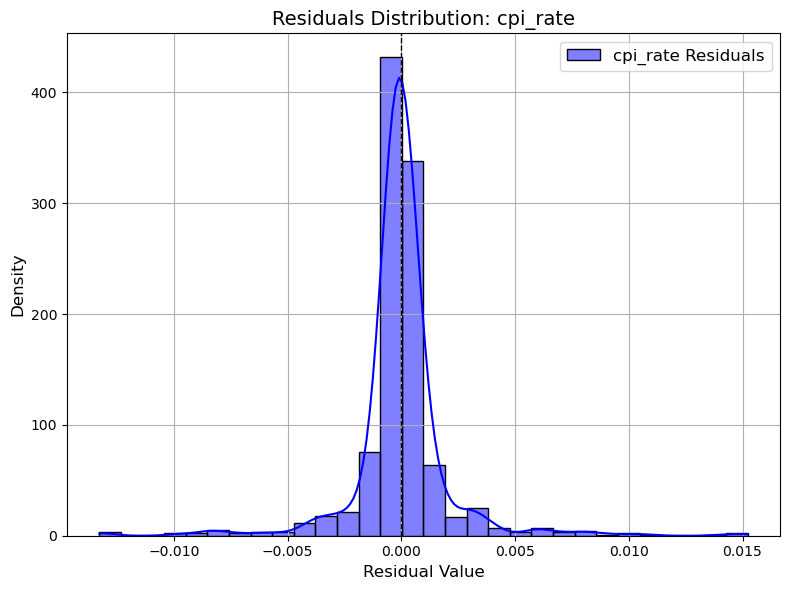

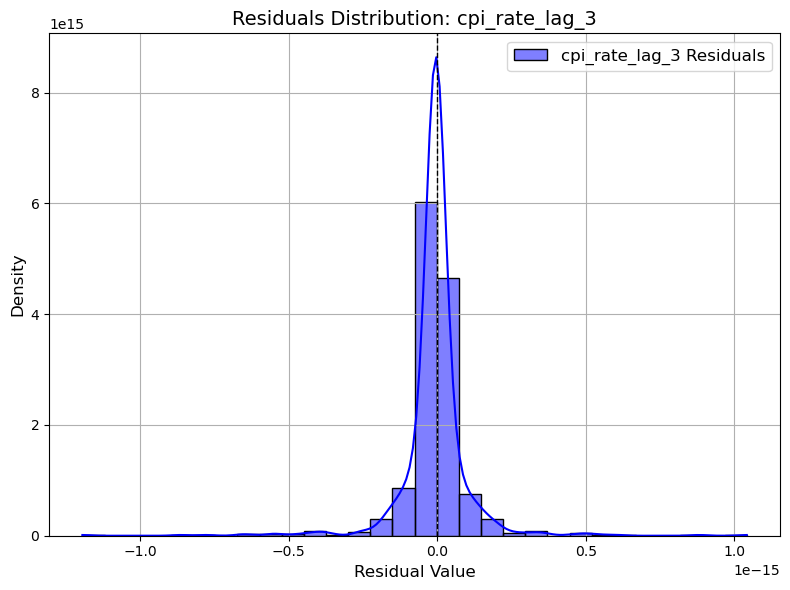

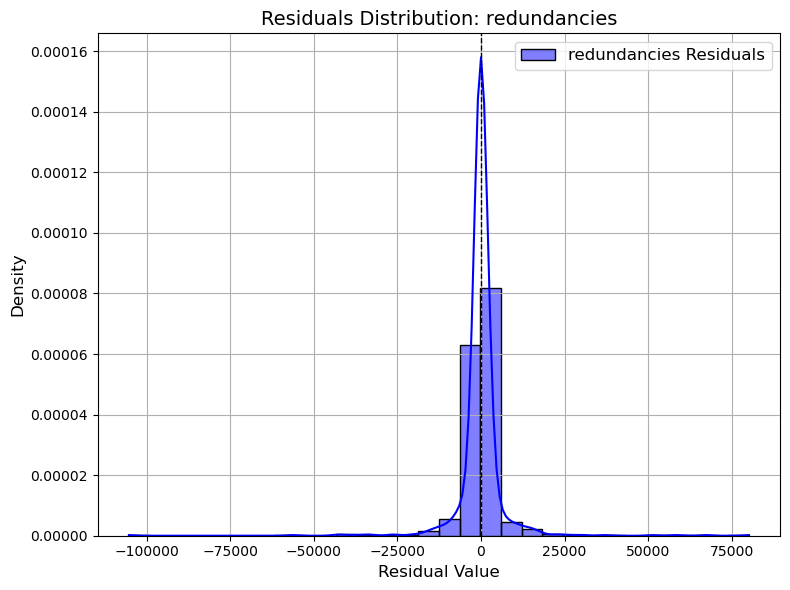

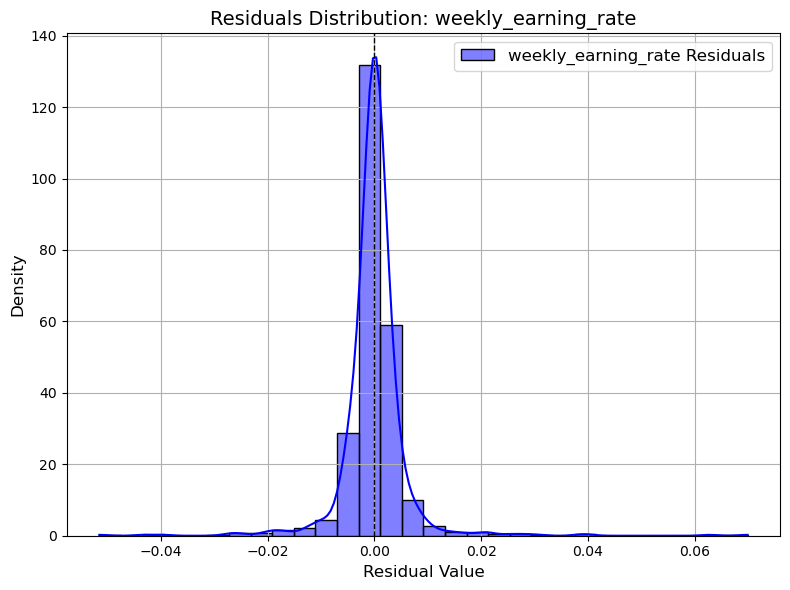

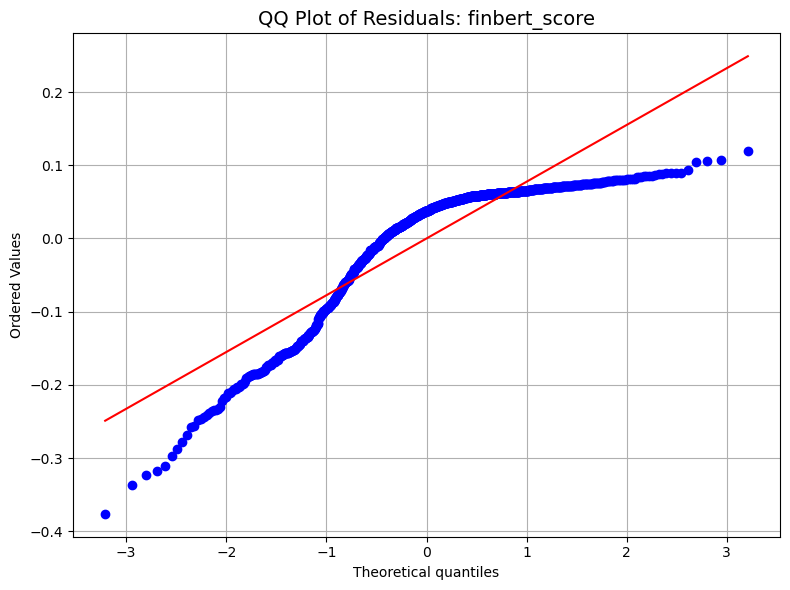

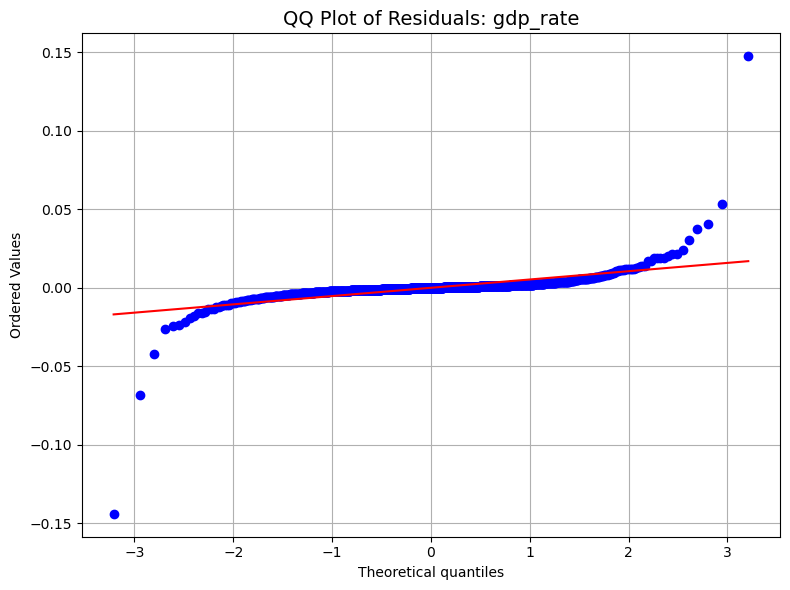

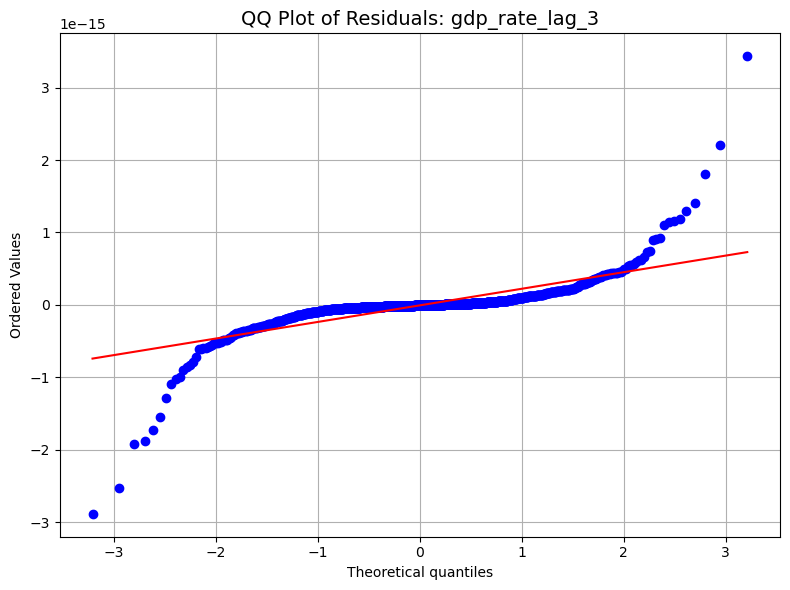

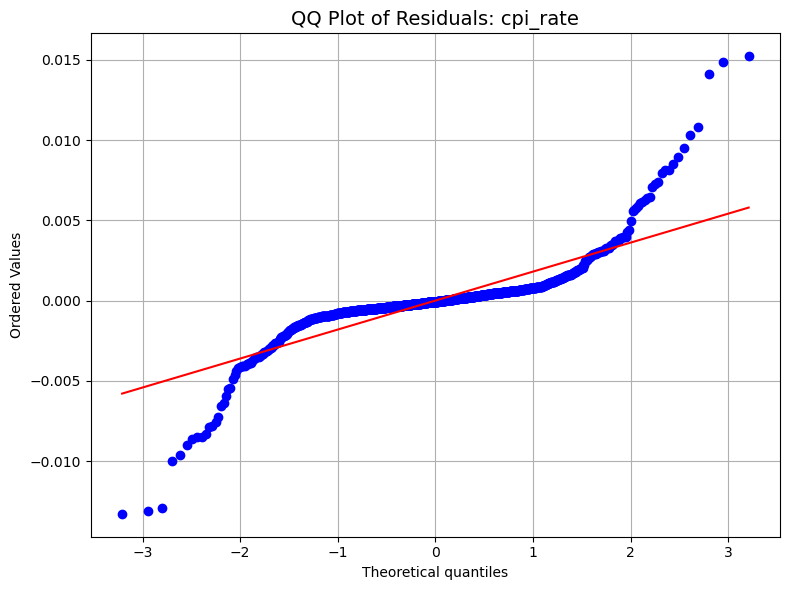

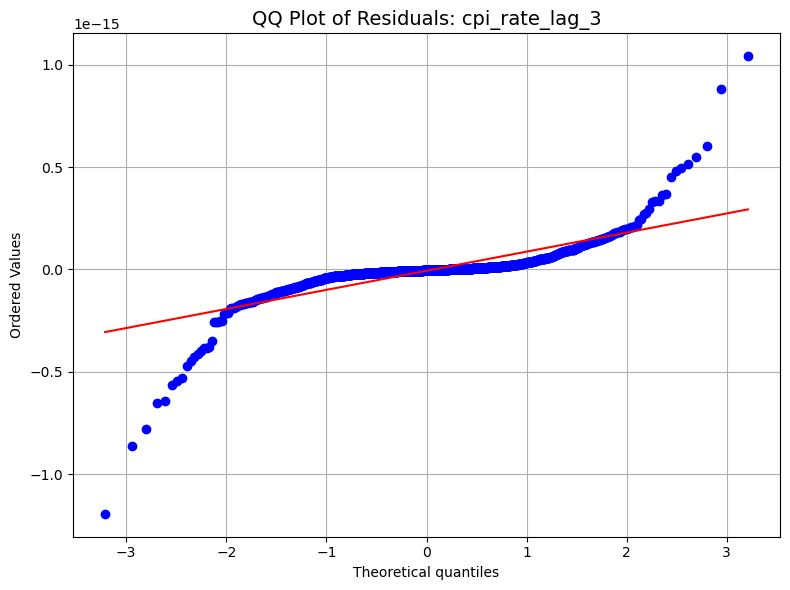

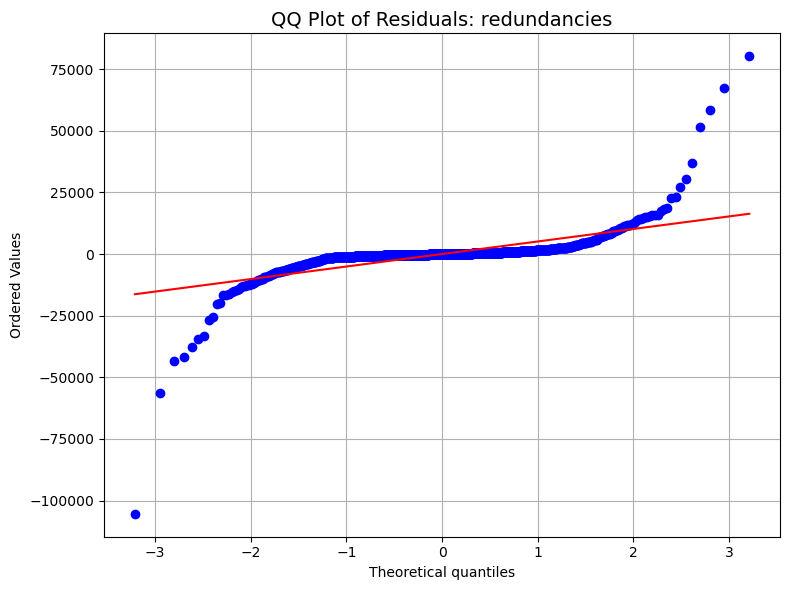

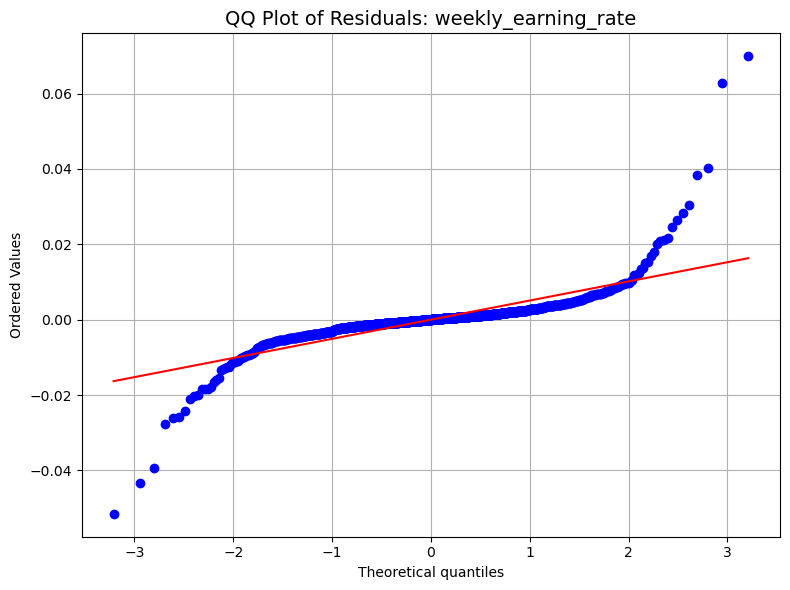

In [100]:
# Extract residuals
residuals = model_fit.resid

# Plot residual distribution for each variable
for col in residuals.columns:
    plt.figure(figsize=(8, 6))
    
    # Histogram and KDE
    sns.histplot(residuals[col], kde=True, bins=30, color='blue', stat='density', label=f'{col} Residuals')
    
    # Add plot details
    plt.title(f'Residuals Distribution: {col}', fontsize=14)
    plt.xlabel('Residual Value', fontsize=12)
    plt.ylabel('Density', fontsize=12)
    plt.axvline(0, color='black', linestyle='--', linewidth=1)
    plt.legend(fontsize=12)
    plt.grid(True)
    plt.tight_layout()
    plt.show()

# Optional: QQ Plot for normality check
for col in residuals.columns:
    plt.figure(figsize=(8, 6))
    
    # QQ plot
    stats.probplot(residuals[col], dist="norm", plot=plt)
    
    # Add plot details
    plt.title(f'QQ Plot of Residuals: {col}', fontsize=14)
    plt.grid(True)
    plt.tight_layout()
    plt.show()


#### **Summary of VAR Model Results**

The optimal lag order of 3 was selected based on the AIC. The model fits the data well with a Log-Likelihood of 76200.1 and a low AIC of -165.269.

#### **Looking at finbert_score:**
- The **constant term** is significant, indicating a strong baseline financial sentiment.
- Past **finbert_score** values (lags 1, 2, 3) do not significantly impact the current score, suggesting sentiment is not strongly autoregressive.
- **GDP rate** and **CPI** are not significant predictors, implying that economic growth and inflation don't strongly influence sentiment in the short term.
- **Redundancies** at **lag 2** have a significant negative effect on sentiment, suggesting layoffs or inefficiencies reduce sentiment.
- **Weekly earning rate** and other macroeconomic variables show little impact.

The VAR model effectively captures relationships between macroeconomic variables, but it performs poorly when we look at the connection between speech tone (finbert_score) and the other variables.

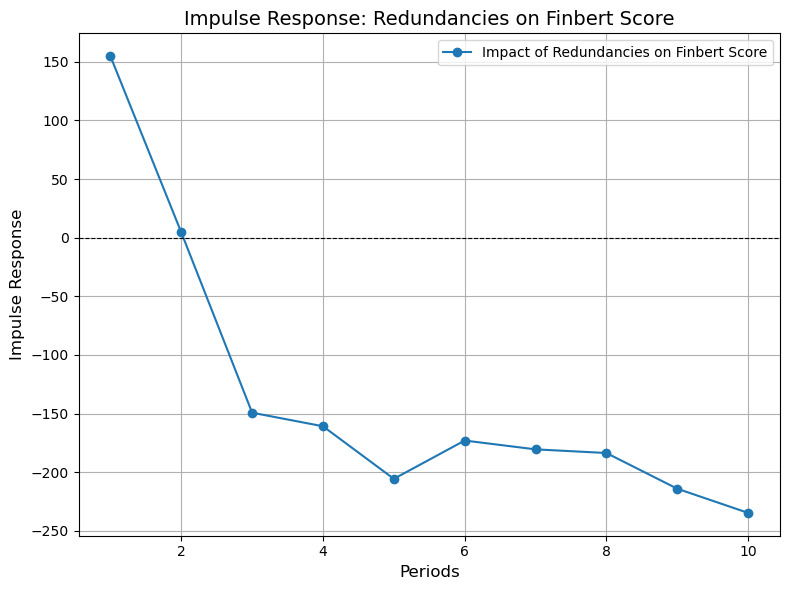

In [104]:
# Generate the impulse response function
irf = model_fit.irf(10)  # Calculate IRFs for 10 periods

# Extract the impulse response for 'redundancies' on 'finbert_score'
response = irf.orth_irfs[:, redundancies_idx, finbert_score_idx]

# Plot the impulse response
plt.figure(figsize=(8, 6))
plt.plot(range(1, 11), response[1:], marker='o', label='Impact of Redundancies on Finbert Score')  # Slice from period 1 to 10

# Add plot details
plt.axhline(0, color='black', linestyle='--', linewidth=0.8)
plt.title('Impulse Response: Redundancies on Finbert Score', fontsize=14)
plt.xlabel('Periods', fontsize=12)
plt.ylabel('Impulse Response', fontsize=12)
plt.legend()
plt.grid(True)
plt.tight_layout()
plt.show()


The **impulse response plot** shows that an initial positive shock to redundancies significantly impacts the Finbert score, with the effect decreasing sharply and becoming negative, stabilizing around -200 in later periods.

**[Table of Contents](#Table_of_contents)**